In [65]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.filters import threshold_otsu
import cv2
from sklearn.cluster import KMeans
from sklearn import mixture
import scipy.stats as stats
import importlib

In [2]:
from deepcardio_utils import *

## Sparks location and image list

In [3]:
mat = loadmat(os.path.join(DATASETS_PATH, MAT_PATH))['xytspark']
sparksDF = pd.DataFrame(mat, columns=['x','y','tIni','tFin'])
sparksDF.head()

,x,y,tIni,tFin
0,71,36,2,37
1,76,37,37,77
2,162,23,81,116
3,207,26,117,152
4,187,10,333,383


In [4]:
imageList = sorted(os.listdir(IMAGE_FOLDER))
imageList[:5]

['170215_RyR-GFP30_RO_01_Serie2_z10000_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10001_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10002_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10003_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10004_ch01.tif']

## Plot images and locate sparks

In [5]:
idx = 130
im = get_image_array(idx)
im.shape

(40, 256)

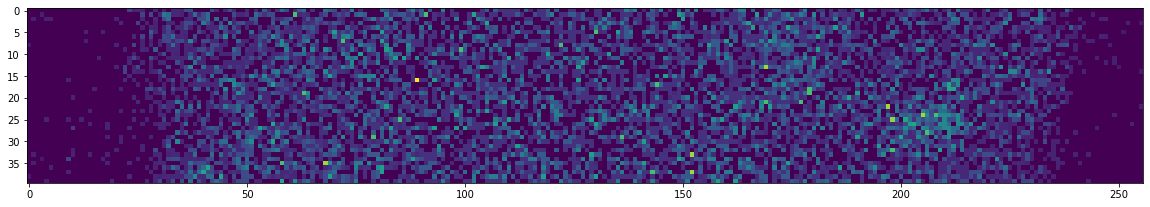

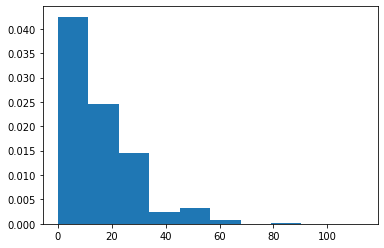

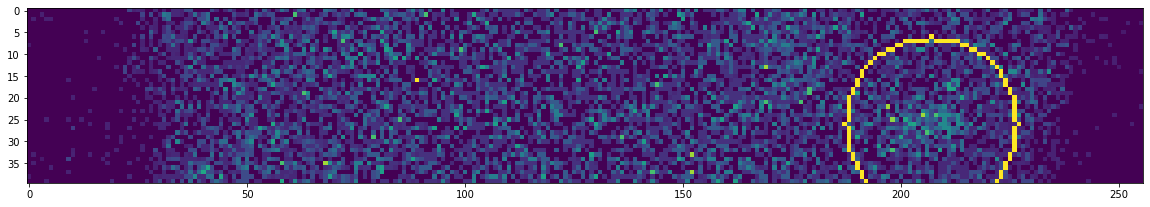

In [6]:
plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten(), density=True)
plt.show()

# find spark
im_ = im.copy()
sparkLocation = get_spark_location(sparksDF, idx)
plt.figure(figsize=(20, 10))
color = int(im_.max())
plt.imshow(cv2.circle(im_, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0))
plt.show()

## Mask on the spark

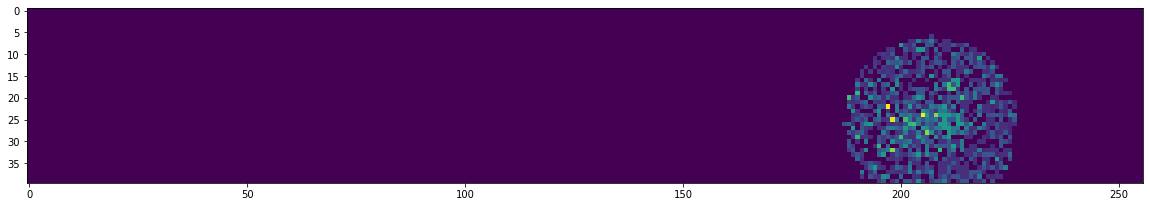

In [7]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)
im[mask == False]=0

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

## Spark highlight

### Binary threshold: arbitrary vs otsu

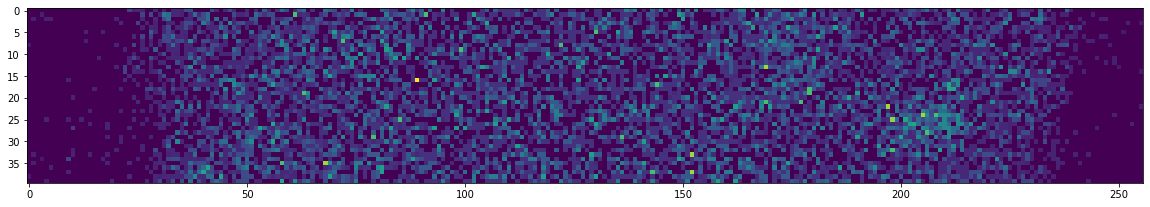

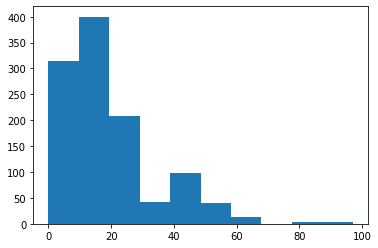

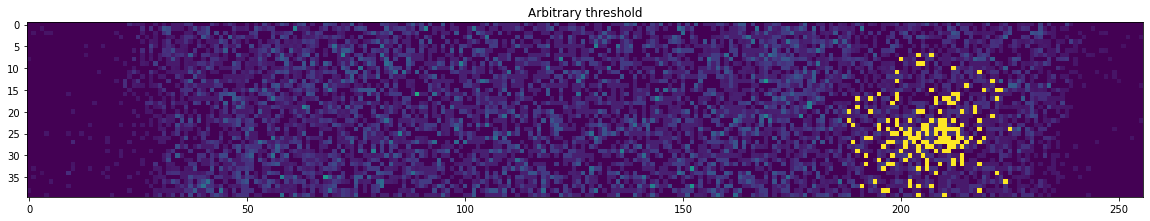

otsu threshold: 16


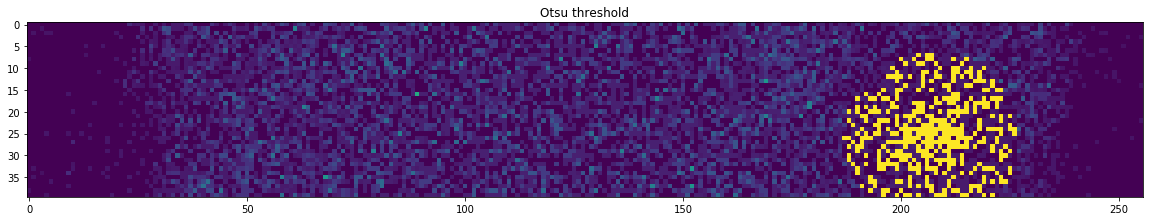

array([ 0, 11, 13, 16, 23, 26, 32, 34, 40, 46, 48, 53, 64, 67, 80, 94, 97],
      dtype=uint8)

In [8]:
idx = 130
im = get_image_array(idx)
im.shape
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

# arbitrary
plt.hist(im[mask].flatten())
plt.show()

im_ = im.copy()
im_[mask] = np.where(im_[mask]>35, 3000, im_[mask])
plt.figure(figsize=(20, 10))
plt.imshow(im_)
plt.title('Arbitrary threshold')
plt.show()

# otsu
otsu = threshold_otsu(im[mask].flatten())
print(f"otsu threshold: {otsu}")

im_ = im.copy()
im_[mask] = np.where(im_[mask]>otsu, 3000, im_[mask])
plt.figure(figsize=(20, 10))
plt.imshow(im_)
plt.title('Otsu threshold')
plt.show()

np.unique(im[mask].flatten())

### KMeans

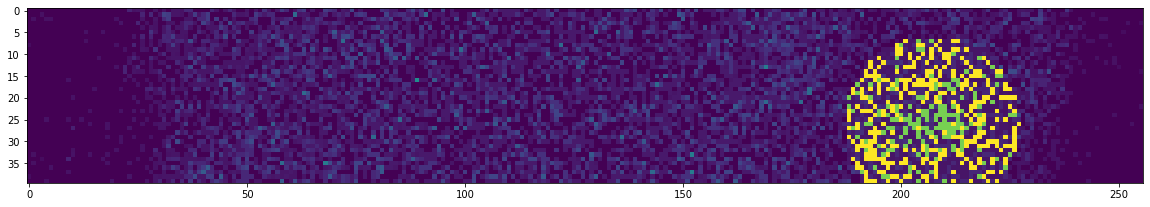

In [9]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

k = KMeans(n_clusters=3).fit(im[mask].reshape(-1,1))
im[mask] = np.where(k.labels_==k.labels_[im[mask].argmax()], 3000, im[mask])
im[mask] = np.where(k.labels_==k.labels_[im[mask].argmin()], 1000, im[mask])

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

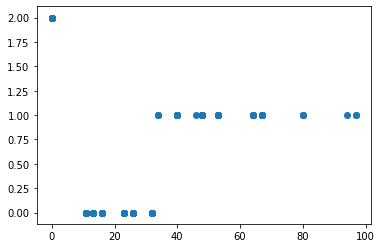

In [10]:
idx = 130
im = get_image_array(idx)
plt.scatter(im[mask].flatten(), k.labels_)
plt.show()

### Gaussian Mixture Models (GMM)

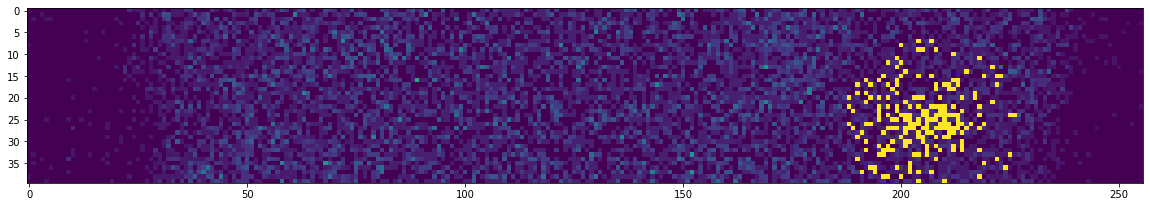

In [11]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

gmm = mixture.GaussianMixture(n_components=3).fit(im[mask].reshape(-1,1))
lab = gmm.predict(im[mask].reshape(-1,1))
im[mask] = np.where(lab==lab[im[mask].argmax()], 3000, im[mask])

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

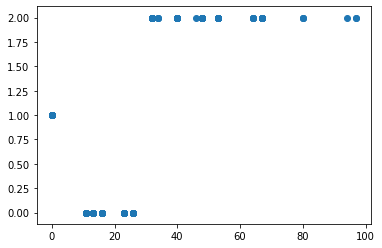

In [12]:
idx = 130
im = get_image_array(idx)
plt.scatter(im[mask].flatten(), lab)
plt.show()

### GMM with optimal BIC number

[9466.05435759548, 9291.038608057626, 3863.803140915015, 3865.0791323268822, 79.79052982740343, 100.25528325099269, -1812.4191074369778, 1286.4976037220201, 1248.569874303485, -254.88218953524787]
...and the winner is GMM model G = 5


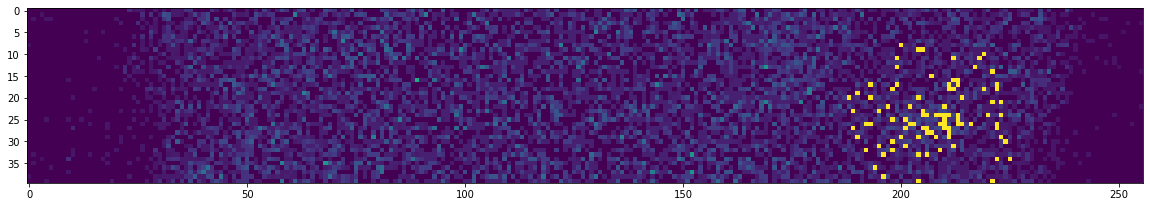

In [13]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

#calcula el BIC per trobar el número de gaussianes òptim
NMAX = 10
bic = []
aic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG).fit(im[mask].reshape(-1,1))
    bic.append(gmm.bic(im[mask].reshape(-1,1))) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim

print(bic)

idx_winner = np.argmin(np.abs(bic))
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

gmm = mixture.GaussianMixture(n_components=(idx_winner+1)).fit(im[mask].reshape(-1,1))
lab = gmm.predict(im[mask].reshape(-1,1))
im[mask] = np.where(lab==lab[im[mask].argmax()], 3000, im[mask])

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

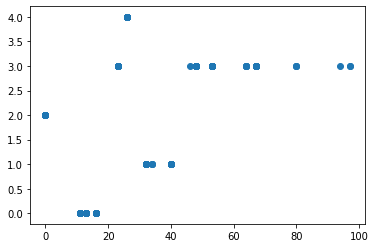

In [14]:
idx = 130
im = get_image_array(idx)
plt.scatter(im[mask].flatten(), lab)
plt.show()

### Using distance info

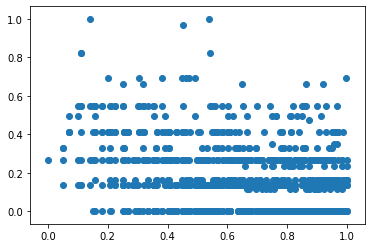

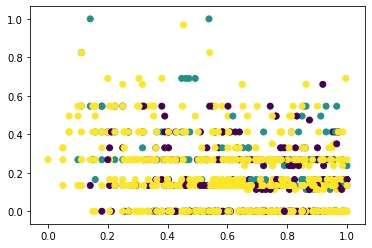

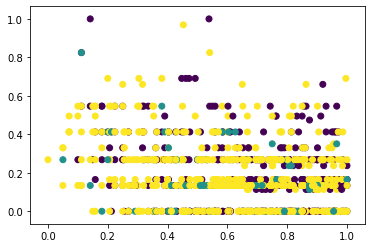

In [15]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

y, x = np.ogrid[:im.shape[0], :im.shape[1]]
dist_from_center = np.sqrt((x - sparkLocation['x'])**2 + (y-sparkLocation['y'])**2)
aux = np.array([dist_from_center[mask].flatten(), im[mask].flatten()])
aux[0] /= aux[0].max()
aux[1] /= aux[1].max()

plt.scatter(aux[0], aux[1])
plt.show()

km = KMeans(n_clusters=3).fit(aux.reshape(-1,2))
plt.scatter(aux[0], aux[1], c=km.labels_)
plt.show()

gmm = mixture.GaussianMixture(n_components=3).fit(aux.reshape(-1, 2))
lab = gmm.predict(aux.reshape(-1, 2))
plt.scatter(aux[0], aux[1], c=lab)
plt.show()

### Combine plot image and spark segmentation

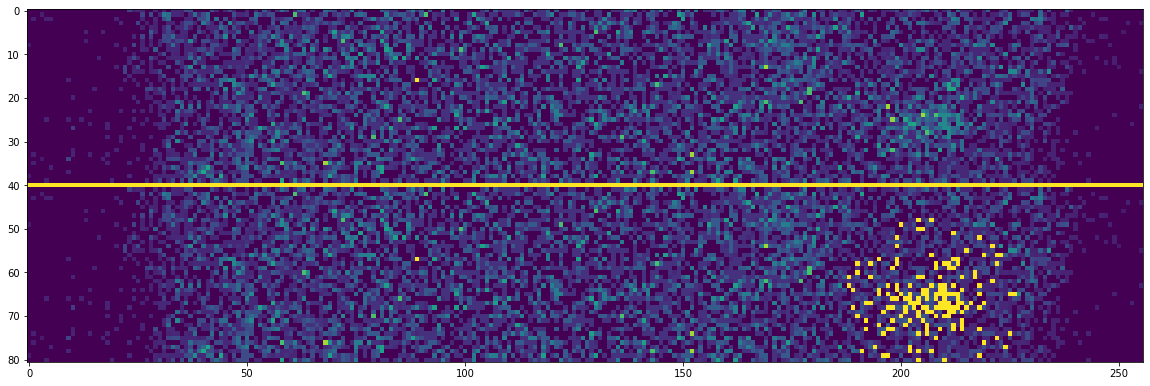

In [16]:
idx = 130
im = get_image_array(idx)
im_ = im.copy()
k = KMeans(n_clusters=3).fit(im_[mask].reshape(-1,1))
im_[mask] = np.where(k.labels_==k.labels_[im_[mask].argmax()], im.max(), im_[mask])

conc_im = np.concatenate((im, np.full((1,im.shape[1]), im_.max()), im_))
plt.figure(figsize=(20,10))
plt.imshow(conc_im)
plt.show()

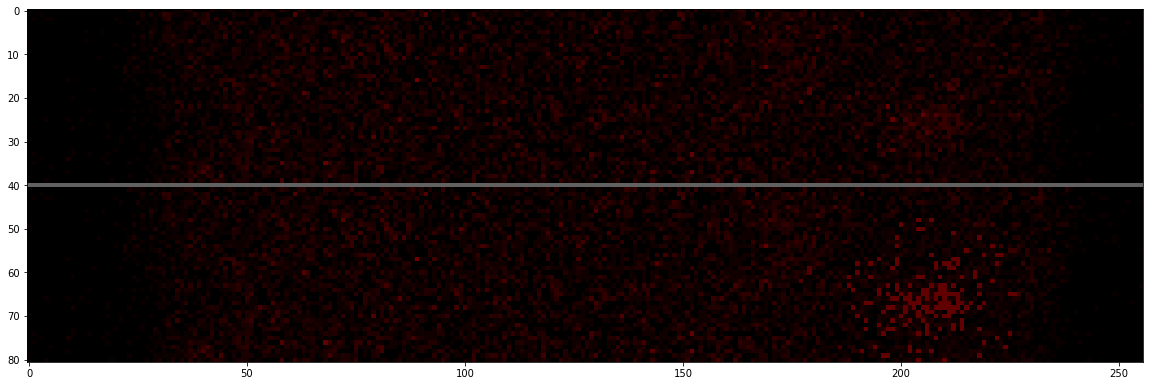

In [17]:
idx = 130
im = cv2.imread(get_image_path(idx))
im_ = im.copy()

sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

k = KMeans(n_clusters=3).fit(im_[mask].reshape(-1,3))
maxRValue = im_[mask,2].max()
maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
maxValueIdx = im_[mask, 2].argmax()
isSparkCond = np.full(im_[mask].shape, False)
isSparkCond[k.labels_ == k.labels_[maxValueIdx], 2] = True
im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])

conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
plt.show()

### savefig spark frames KMeans

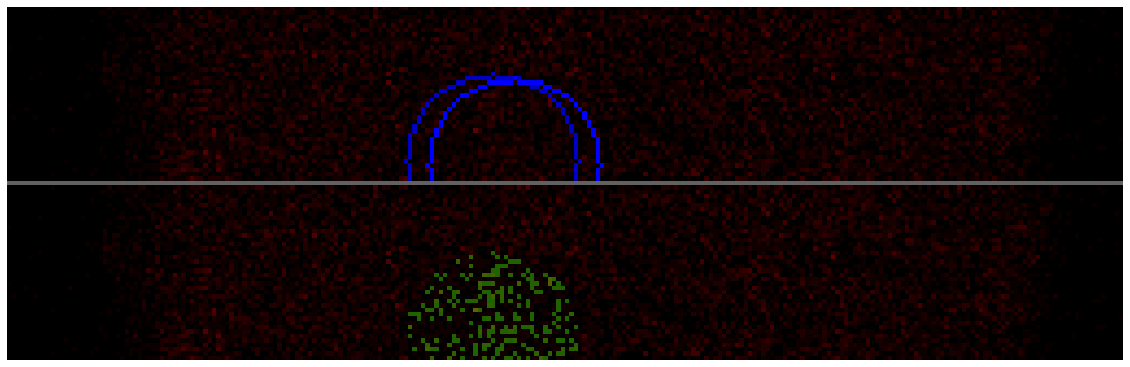

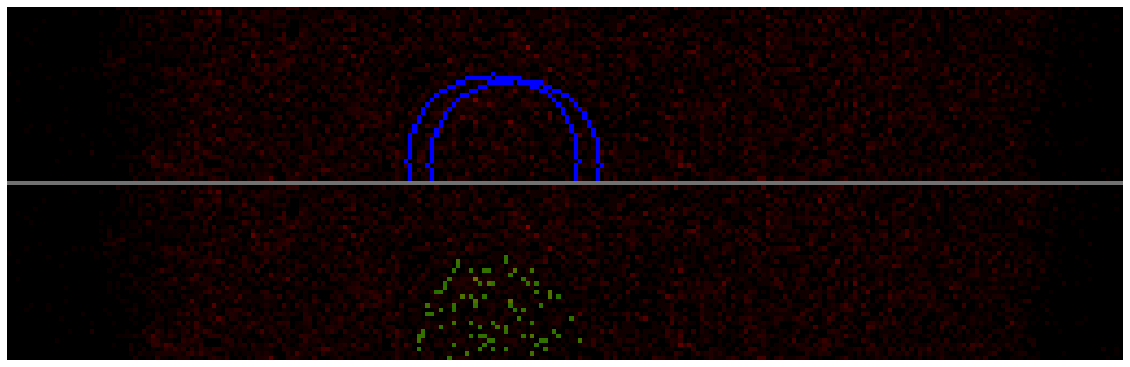

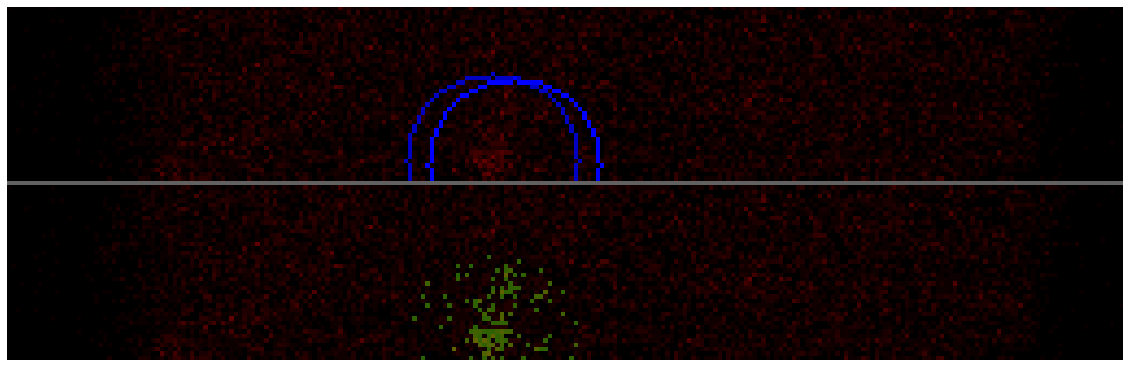

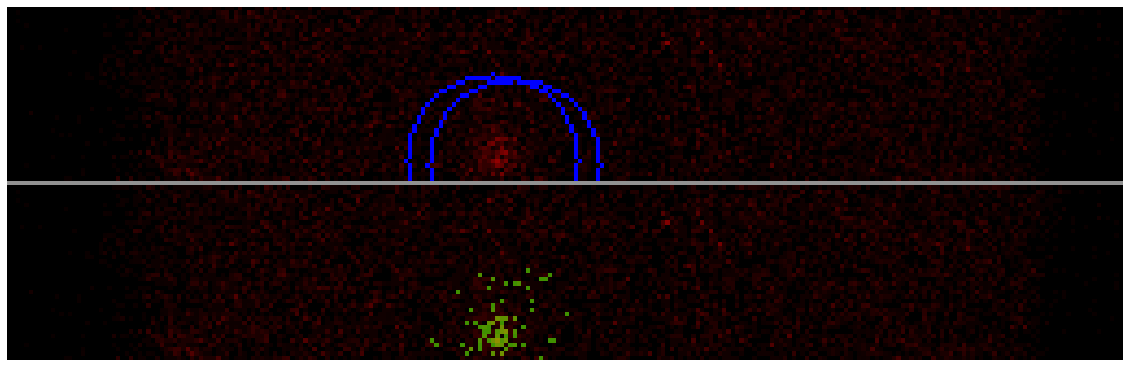

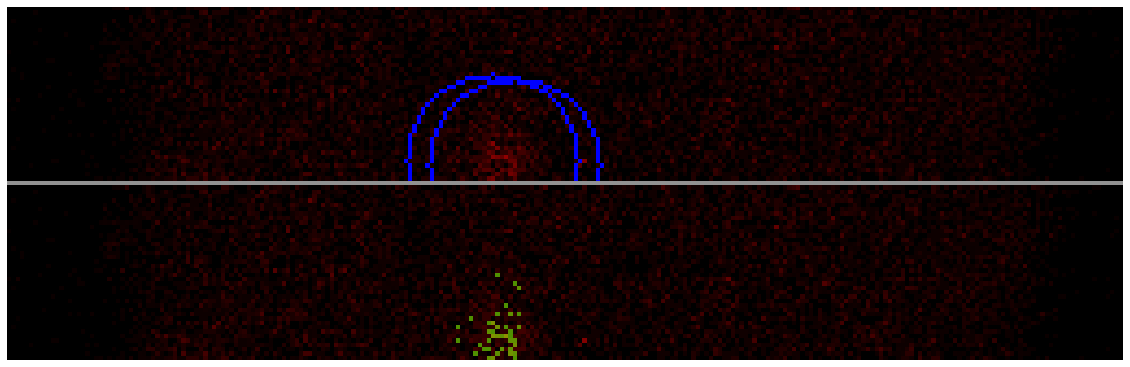

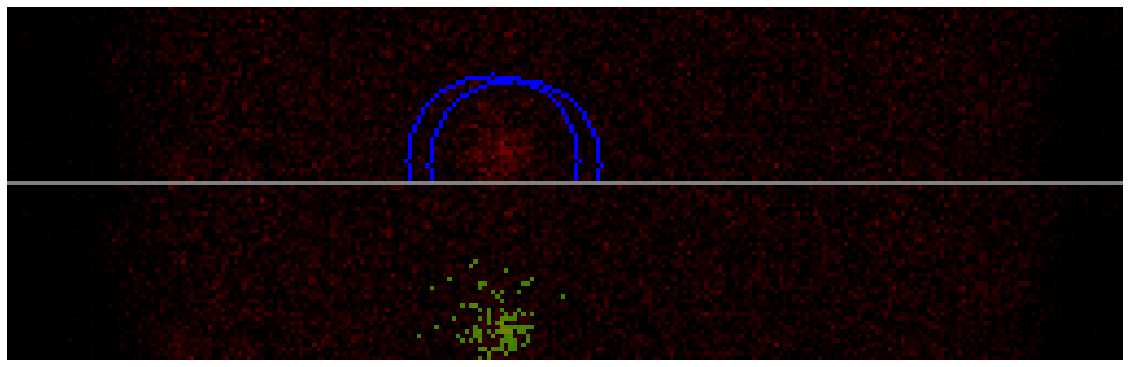

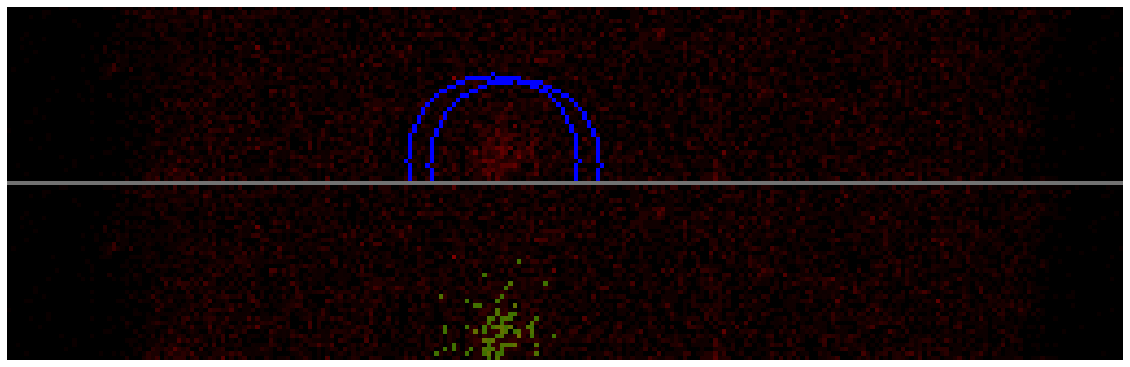

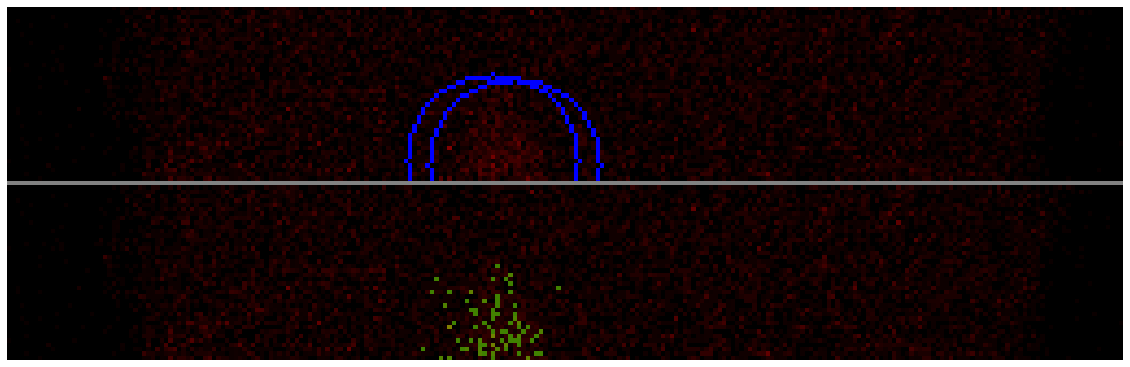

In [18]:
idx = 2008
for idx in range(2003, 2010+1):
    im = cv2.imread(get_image_path(idx))
    im_ = im.copy()

    sparkLocations = get_spark_location(sparksDF, idx)
    for i, sparkLocation in sparkLocations.iterrows():
        color = int(im.max()*2)
        cv2.circle(im, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)

        mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

        k = KMeans(n_clusters=3).fit(im_[mask].reshape(-1,3))
        maxRValue = im_[mask,2].max()
        maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
        maxValueIdx = im_[mask, 2].argmax()
        isSparkCond = np.full(im_[mask].shape, False)
        isSparkCond[k.labels_ == k.labels_[maxValueIdx], 1] = True
        im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])

    conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.title(f"{idx}")
    # plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

### Use BIC for the number of mixtures

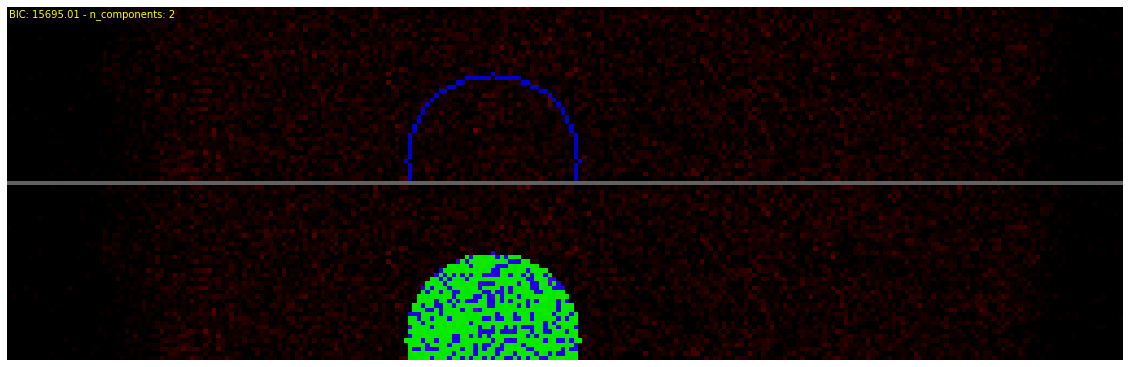

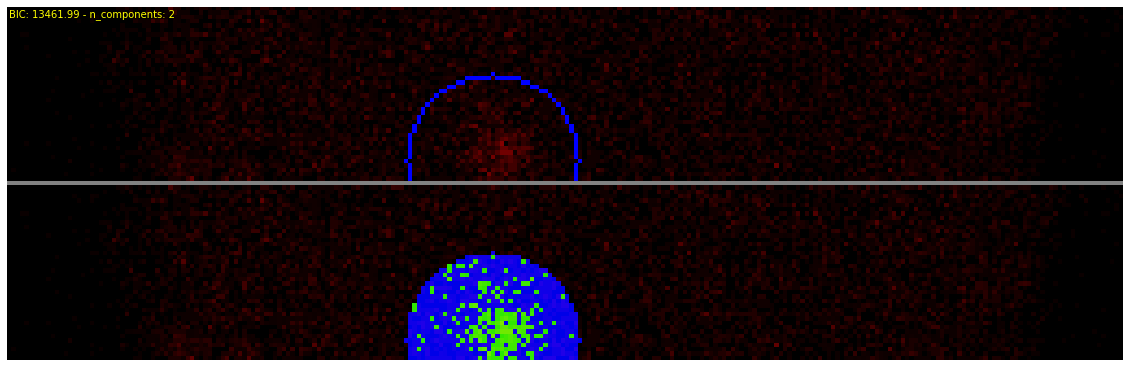

In [19]:
for idx in [2003, 2008]:
    im = cv2.imread(get_image_path(idx))
    im_ = im.copy()

    sparkLocations = get_spark_location(sparksDF, idx)
    gmmCounts = []
    # only first one
    i, sparkLocation = next(sparkLocations.iterrows())
    color = int(im.max()*2)

    mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)
    
    nComp, bic = get_optimal_ncomponents_and_bic_gmm(im[mask].reshape(-1,1))

    gmmCounts.append(nComp)
    gmm = mixture.GaussianMixture(n_components=nComp).fit(im[mask].reshape(-1,3))
    lab = gmm.predict(im[mask].reshape(-1,3))

    maxRValue = im_[mask,2].max()
    maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
    maxValueIdx = im_[mask, 2].argmax()
    isSparkCond = np.full(im_[mask].shape, False)
    isSparkCond[lab == lab[maxValueIdx], 1] = True
    # im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])
    im_[mask, lab]  = 1000

    cv2.circle(im, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)
    conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.title(f"{idx}")
    plt.text(0, 0, f"BIC: {round(bic,2)} - n_components: {', '.join(str(c) for c in gmmCounts)}", c='yellow', verticalalignment='top')
    # plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

### Utilitzar pixels amb valor 0 vs no utilitzarlos

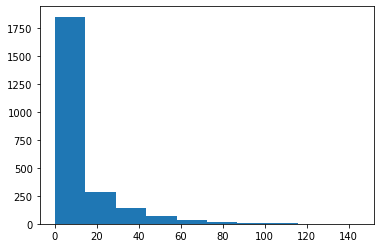

[10.88098443 41.47561145] [0.61825768 0.38174232] [103.0593374  657.03765029]


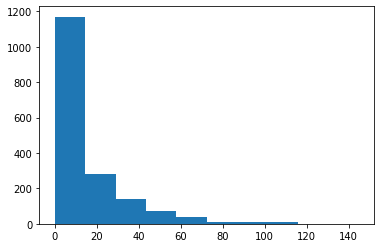

[53.85709833 20.5054524 ] [0.32890184 0.67109816] [563.55747594  53.01059147]


In [101]:
idx=2006

im = cv2.imread(get_image_path(idx))
im_ = im.copy()

mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

# tots els pixels
plt.hist(im[mask].flatten())
plt.show()

sparkLocations = get_spark_location(sparksDF, idx)
# only first one
i, sparkLocation = next(sparkLocations.iterrows())

nComp, bic = get_optimal_ncomponents_and_bic_gmm(im[mask].reshape(-1,1))

gmm = mixture.GaussianMixture(n_components=nComp).fit(im[mask].reshape(-1,3))
lab = gmm.predict(im[mask].reshape(-1,3))

print(gmm.means_[:, 2], gmm.weights_, gmm.covariances_[:, 2, 2])


# nomes pixels > 0
mask = mask & (im[:,:,2]>0)
plt.hist(im[mask].flatten())
plt.show()

sparkLocations = get_spark_location(sparksDF, idx)
# only first one
i, sparkLocation = next(sparkLocations.iterrows())

nComp, bic = get_optimal_ncomponents_and_bic_gmm(im[mask].reshape(-1,1))

gmm = mixture.GaussianMixture(n_components=nComp).fit(im[mask].reshape(-1,3))
lab = gmm.predict(im[mask].reshape(-1,3))

print(gmm.means_[:, 2], gmm.weights_, gmm.covariances_[:, 2, 2])

### Determine when the spark is visible with BIC

The idea is to use the BIC of the GMM model, used to segment the pixels of the spark, to determine in which frames the spark is more visible. To do it the bic of the best GMM model (various n_components are tried for each frame) is stored in bics_list, and then another GMM is applied to this list (with optimal n_components number as well). The cluster containing the best bic will be the one where the spark is more visible.

/Users/aleixsacrest/opt/anaconda3/envs/ia373v/lib/python3.7/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


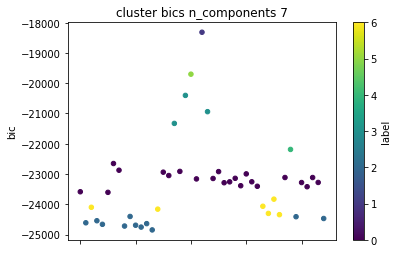

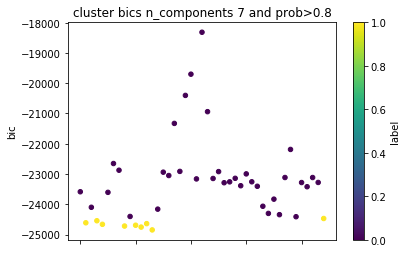

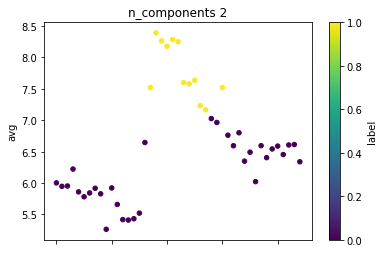

In [95]:
sparkS = sparksDF.loc[26, :]
bics_list = []
value_mean_list = []
gmmCounts = []

for idx in range(sparkS['tIni'], sparkS['tFin']):
    im = cv2.imread(get_image_path(idx))
    im_ = im.copy()

    mask = get_mask(im.shape[0], im.shape[1], sparkS['x'], sparkS['y'], 20)
    nComp, bic = get_optimal_ncomponents_and_bic_gmm_(im[mask].reshape(-1,1), nmin=2)
    gmmCounts.append(nComp)
    
    bics_list.append(round(bic,2))
    value_mean_list.append(im[mask].reshape(-1,1).mean())

bics = np.array(bics_list).reshape(-1, 1)
# k = KMeans(n_clusters=2).fit(bics)
nComp, bic = get_optimal_ncomponents_and_bic_gmm_(bics, nmin=2)

gmm = mixture.GaussianMixture(n_components=nComp).fit(bics)
visibilityLabels = gmm.predict(bics)
visLabel = visibilityLabels[np.argmin(bics)]
df = pd.DataFrame([bics_list, visibilityLabels], index=['bic', 'label']).T.reset_index()
df.plot.scatter(x='index', y='bic', c='label', cmap='viridis')
plt.title(f"cluster bics n_components {nComp}")
plt.show()

predictProbaDF = pd.DataFrame(gmm.predict_proba(bics))
sparkMixtureCol = predictProbaDF.loc[np.argmin(bics), :].argmax()
visibilityLabels = (predictProbaDF.loc[:, sparkMixtureCol] > .8).astype(int)
visLabel = 1
df = pd.DataFrame([bics_list, visibilityLabels], index=['bic', 'label']).T.reset_index()
df.plot.scatter(x='index', y='bic', c='label', cmap='viridis')
plt.title(f"cluster bics n_components {nComp} and prob>0.8")
plt.show()

kk = np.array(value_mean_list).reshape(-1,1)
nComp, bic = get_optimal_ncomponents_and_bic_gmm_(kk, nmin=2)
gmm = mixture.GaussianMixture(n_components=nComp).fit(kk)
avgLabels = gmm.predict(kk)
df = pd.DataFrame([value_mean_list, avgLabels], index=['avg', 'label']).T.reset_index()
df.plot.scatter(x='index', y='avg', c='label', cmap='viridis')
plt.title(f"n_components {nComp}")
plt.show()

- predict_proba per veure la probabilitat de cada gaussiana
- inici de spark amb canvi sobtat de valor

### Highlight spark when visible

In [82]:
def get_optimal_ncomponents_and_bic_gmm_(data, nmin=1, nmax=10):
    #calcula el BIC per trobar el número de gaussianes òptim
    bic = []
    for kG in np.arange(nmin,nmax+1):
        gmm = mixture.GaussianMixture(n_components=kG).fit(data)
        bic.append(gmm.bic(data)) #cada cop va afegint el bic amb kG+1, així ho tens tot en un vector i pots calcualr el mínim
    return np.argmin(bic)+nmin, min(bic)

get_optimal_ncomponents_and_bic_gmm_(im[mask].reshape(-1, 3))

(10, -25660.07416291124)

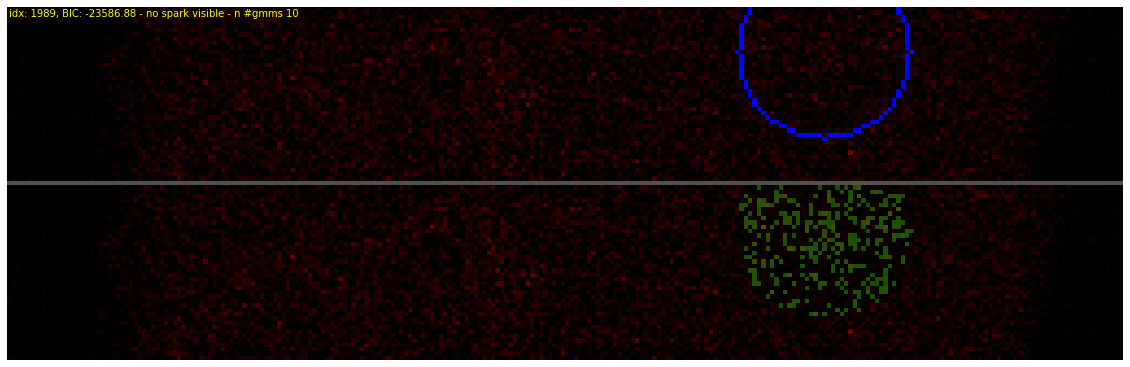

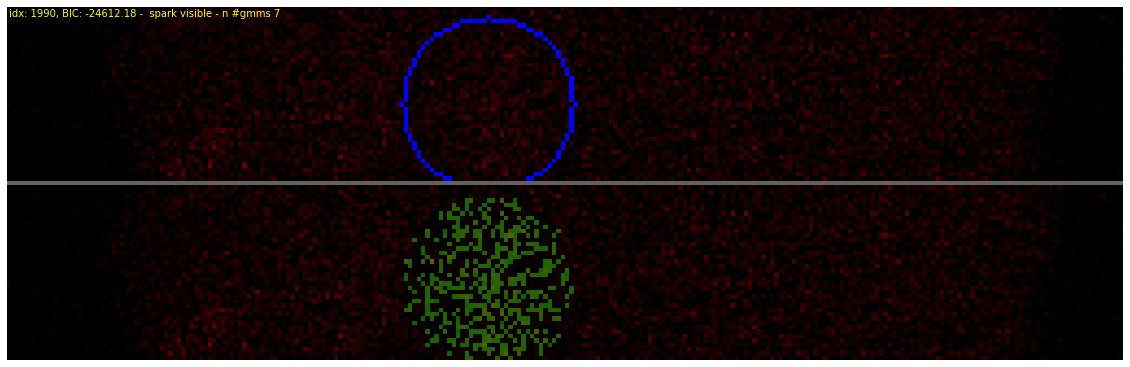

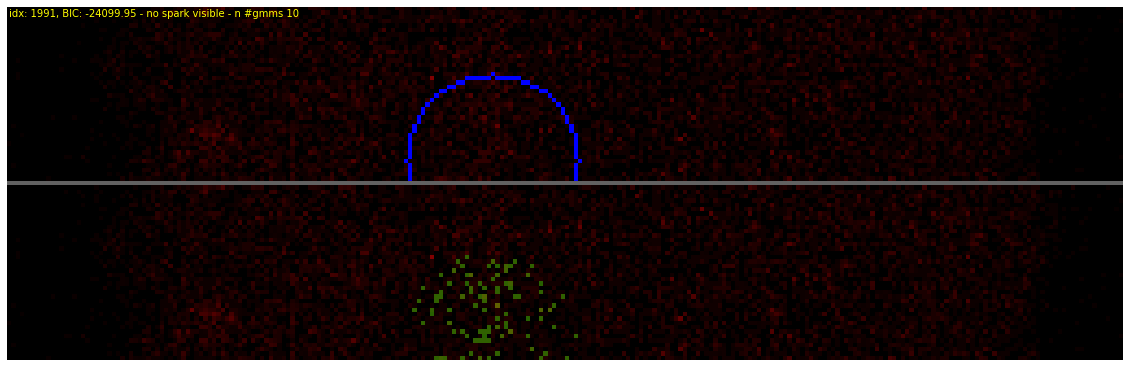

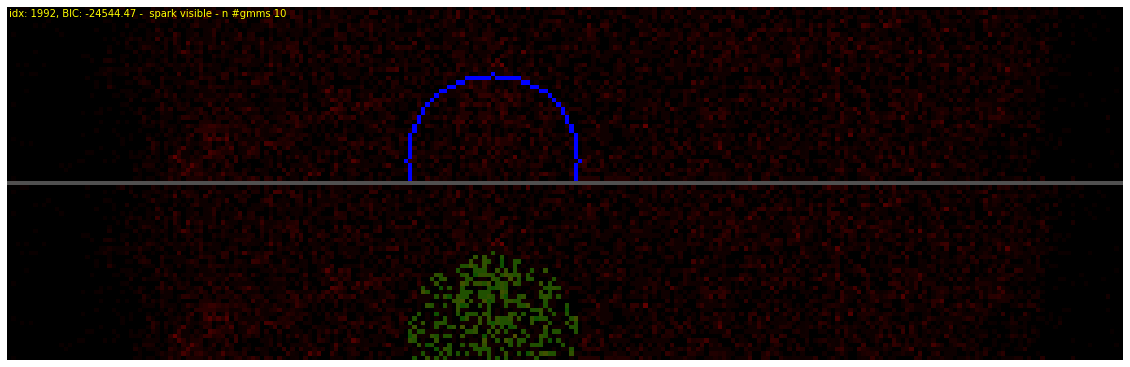

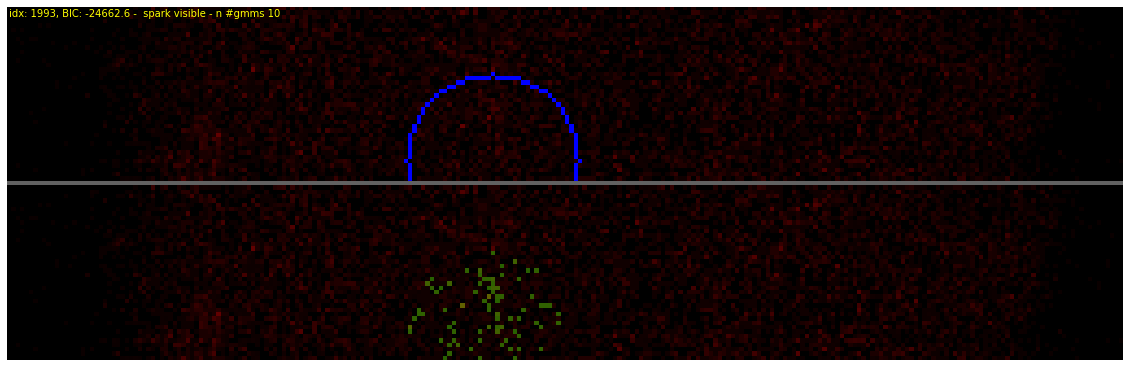

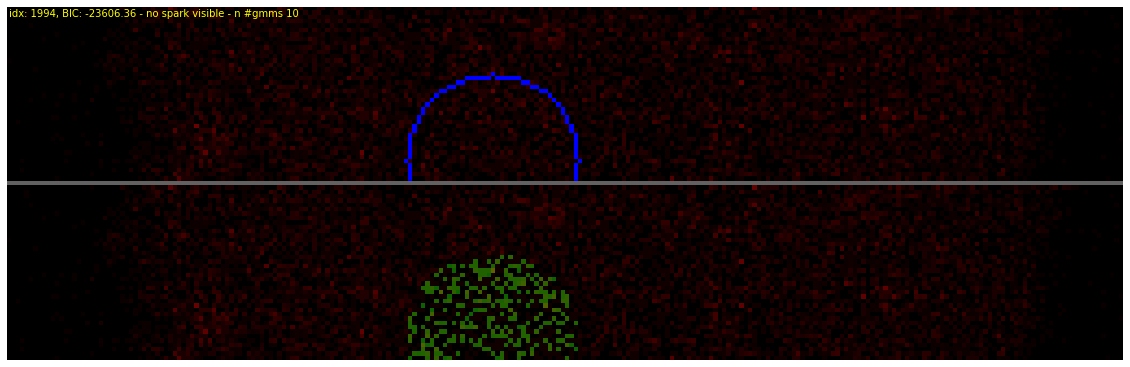

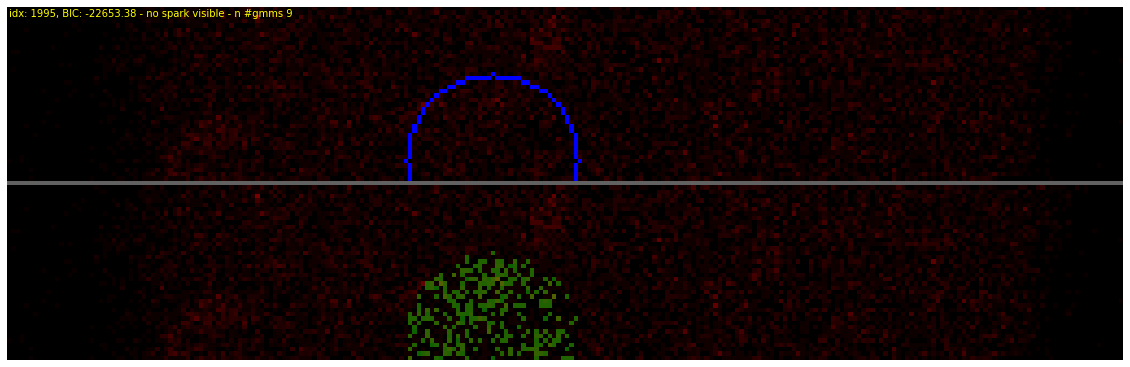

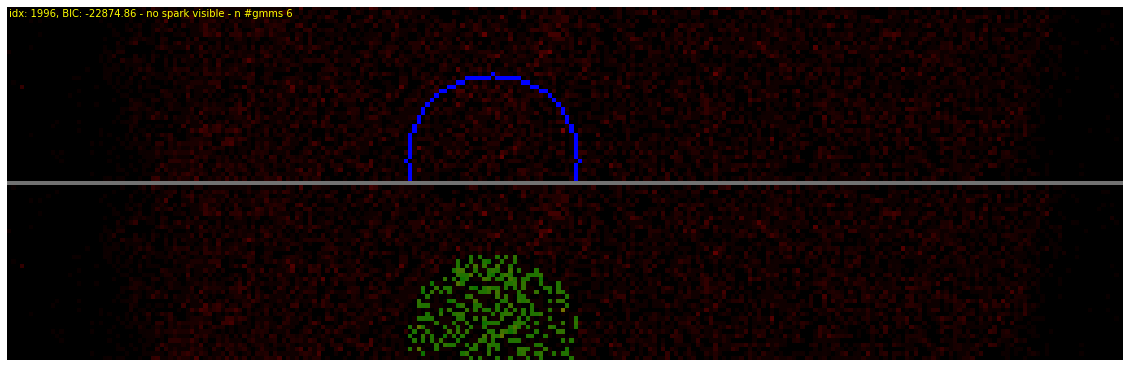

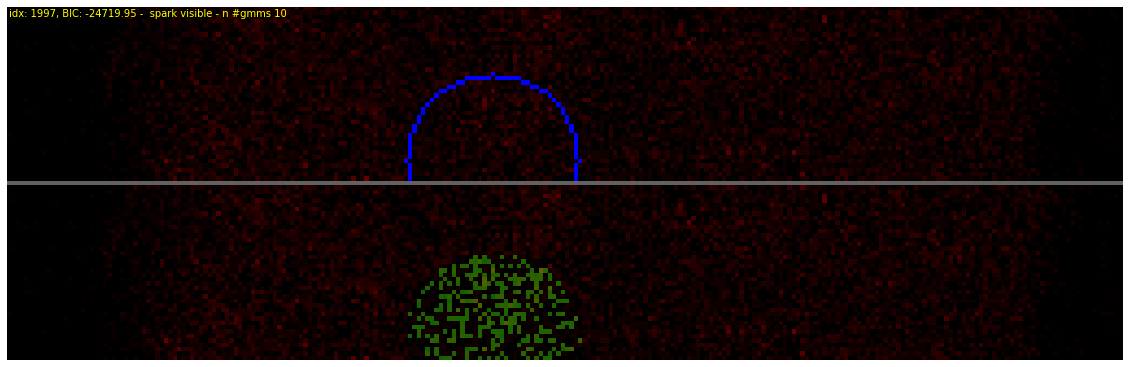

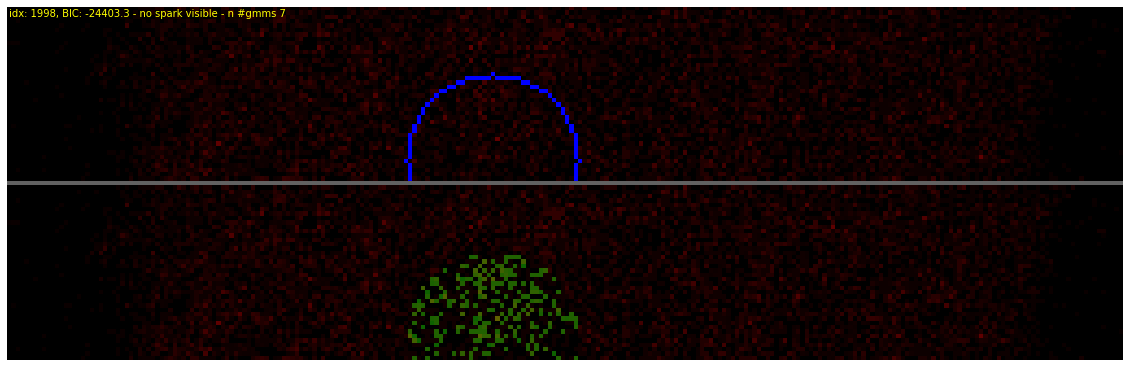

/Users/aleixsacrest/opt/anaconda3/envs/ia373v/lib/python3.7/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


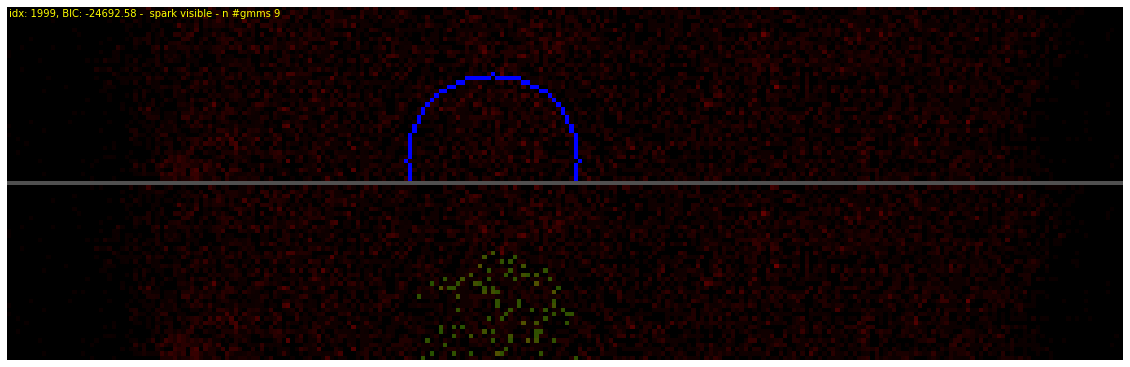

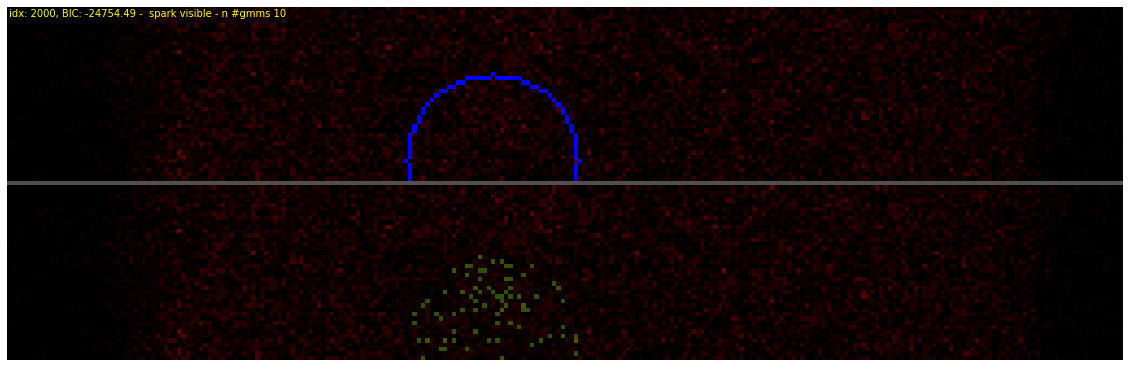

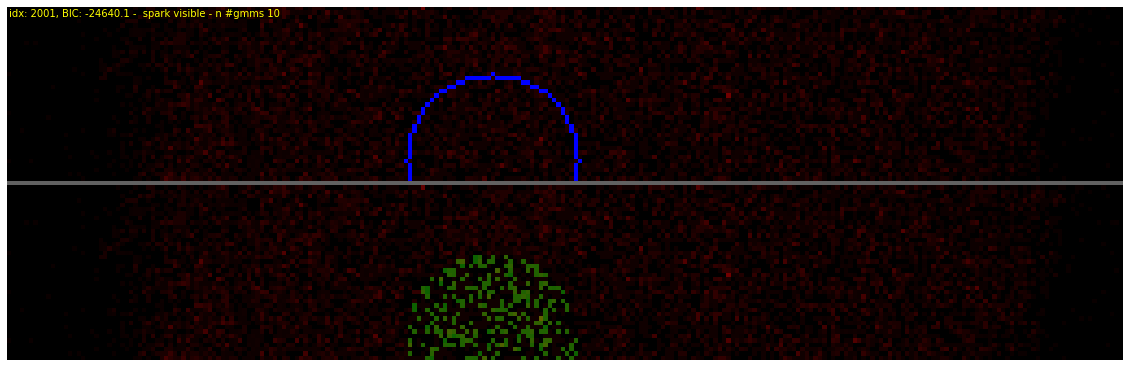

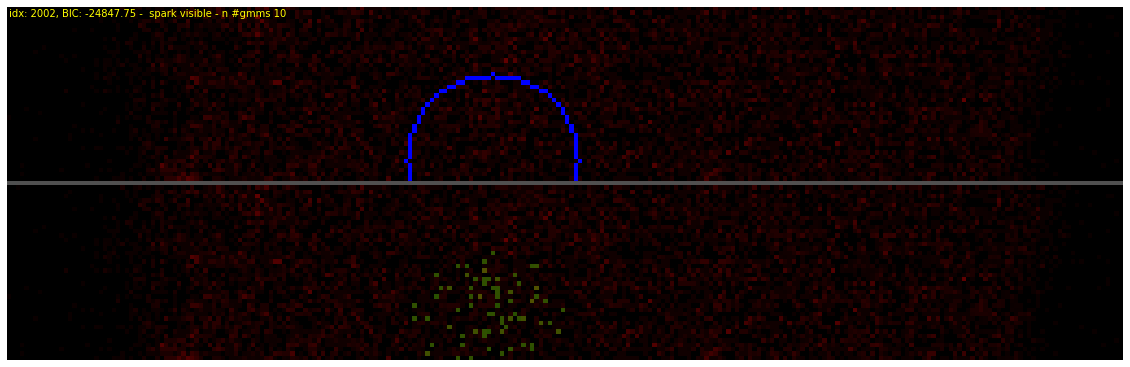

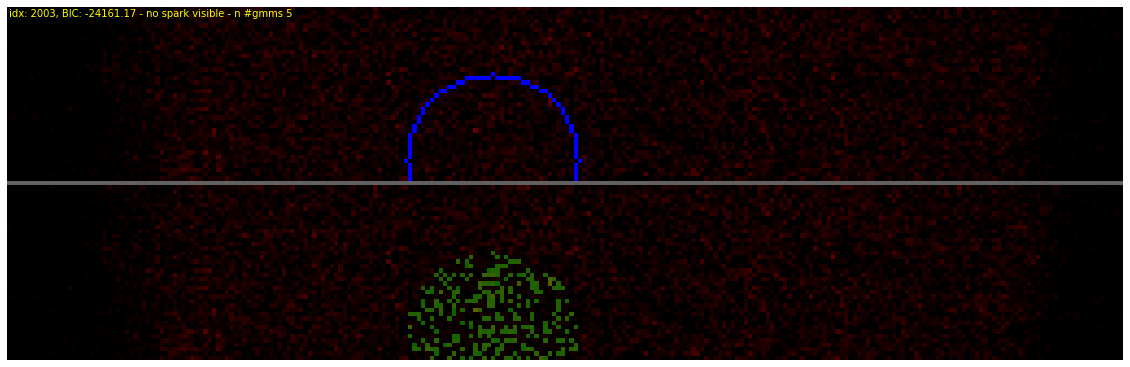

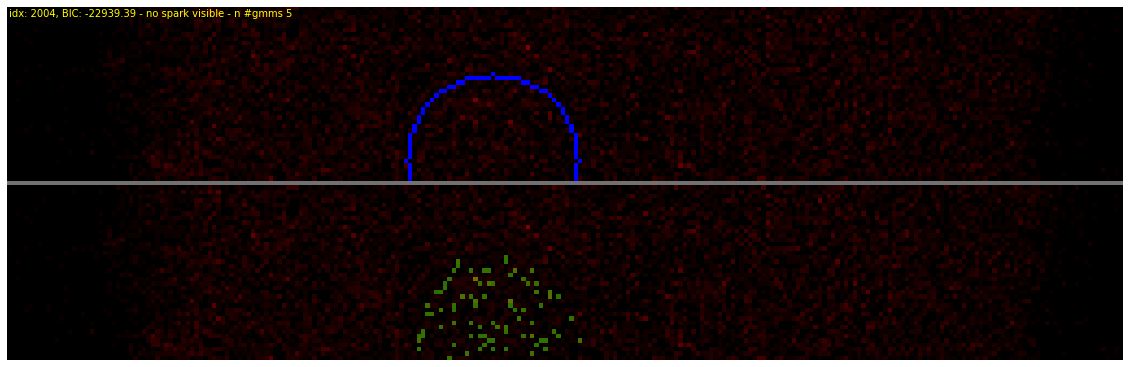

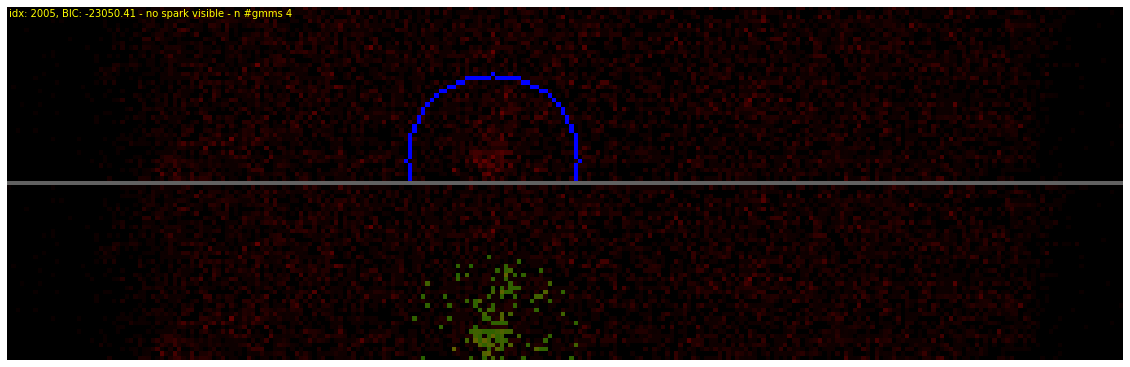

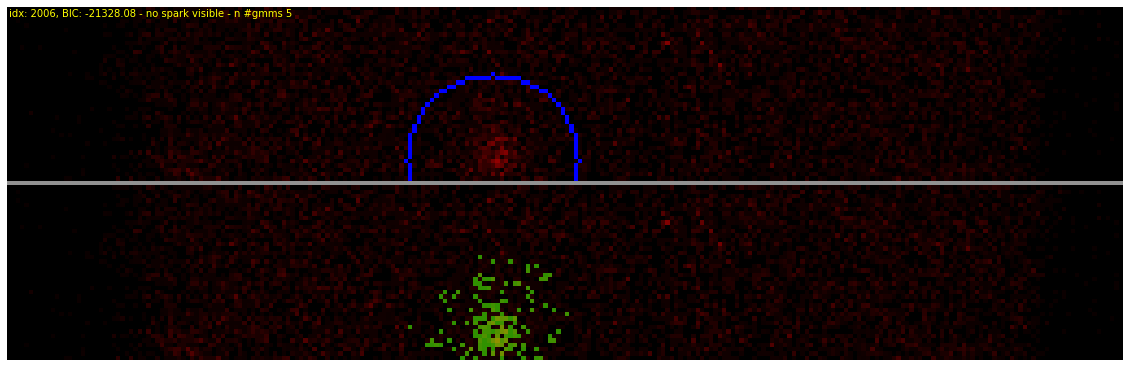

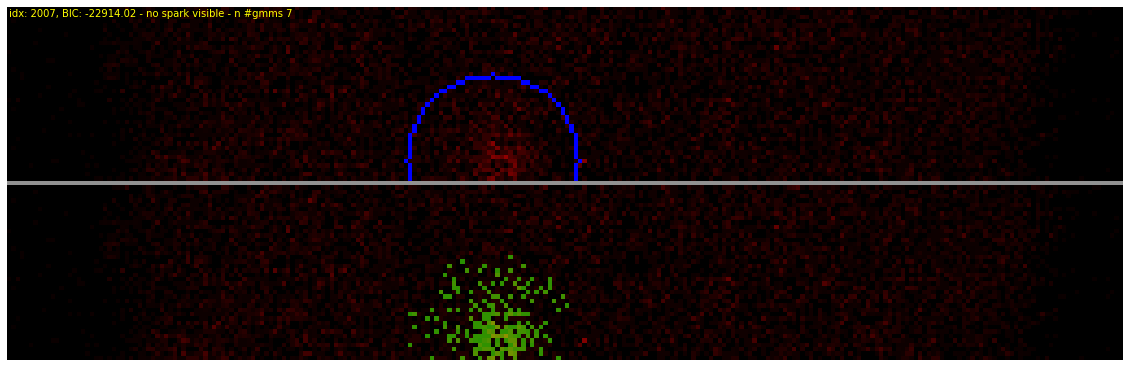

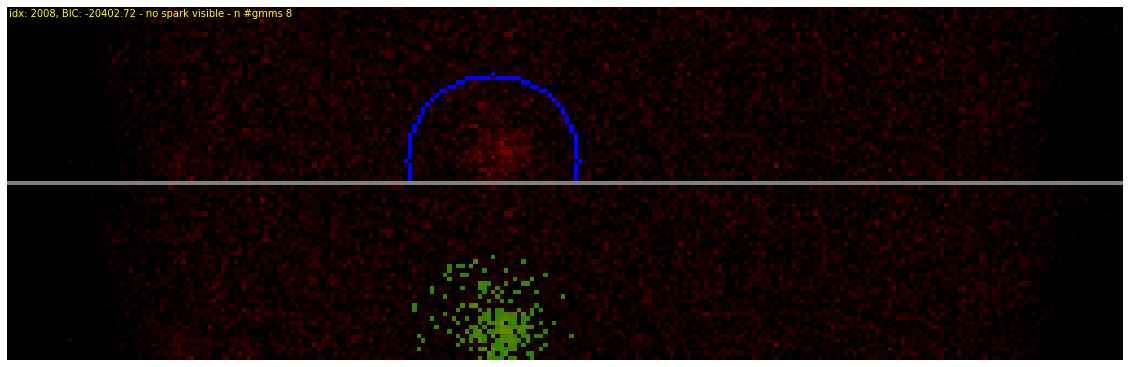

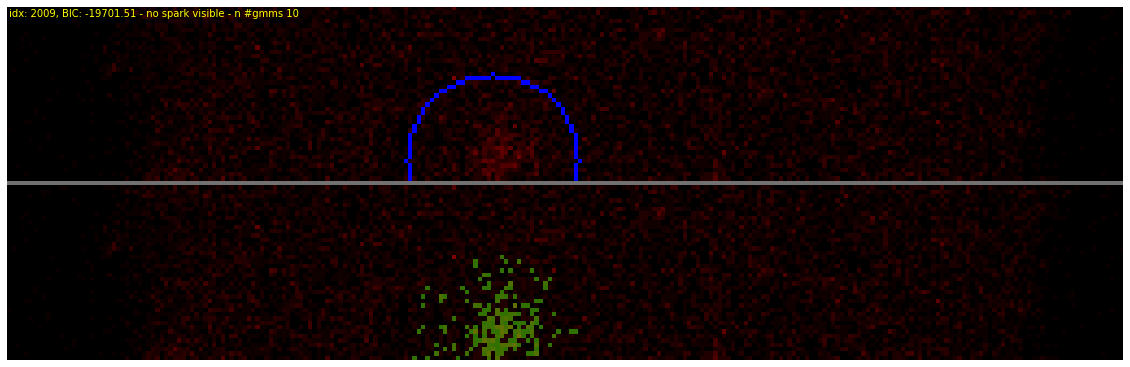

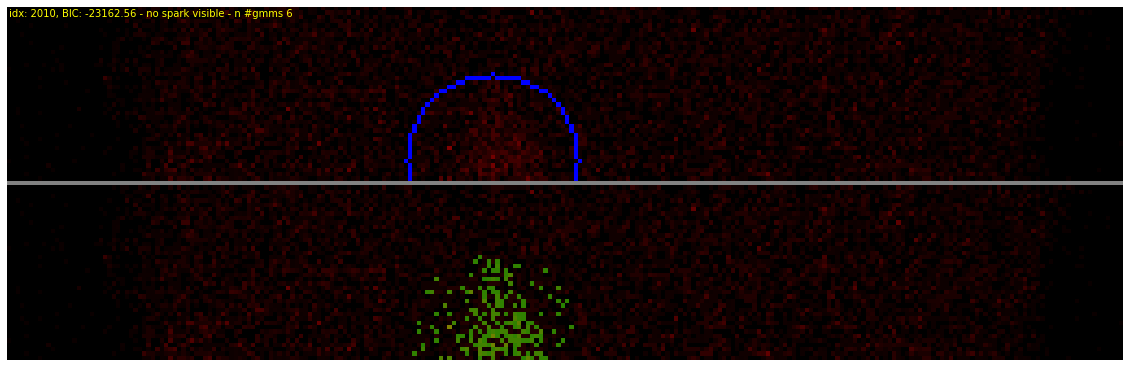

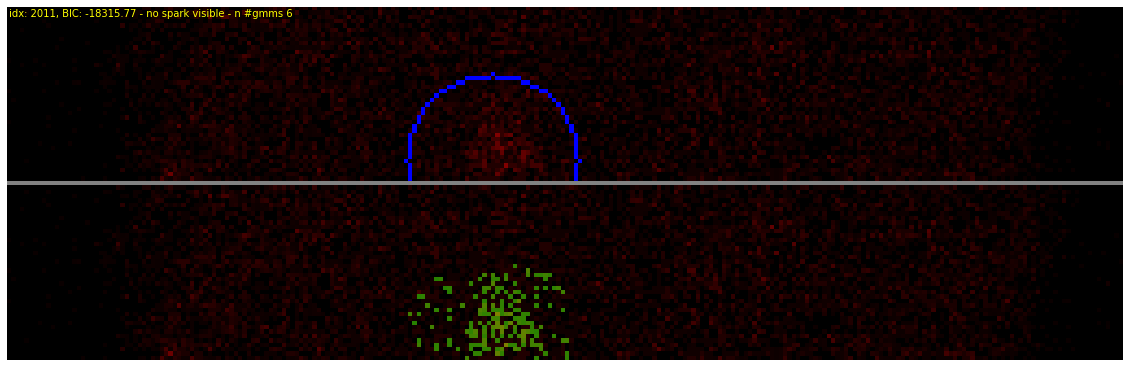

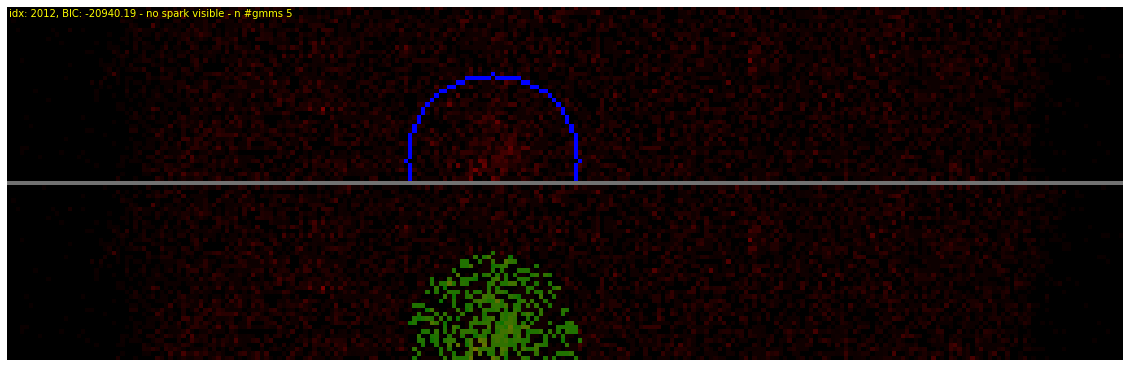

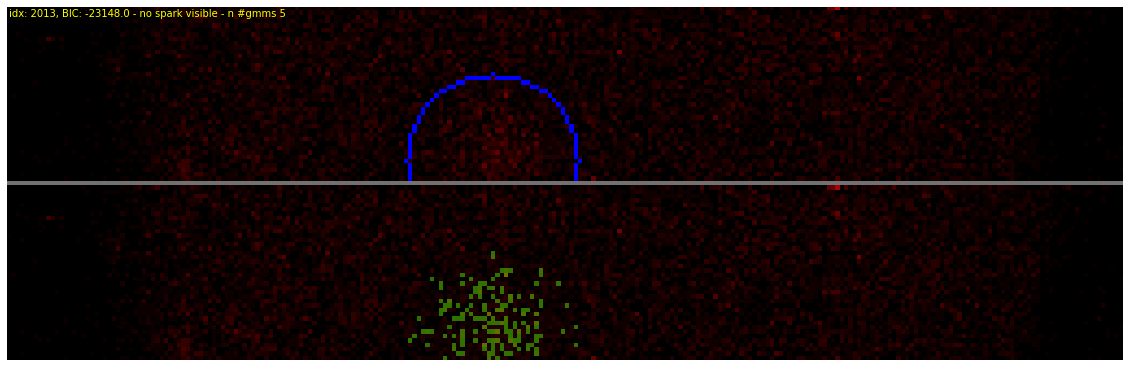

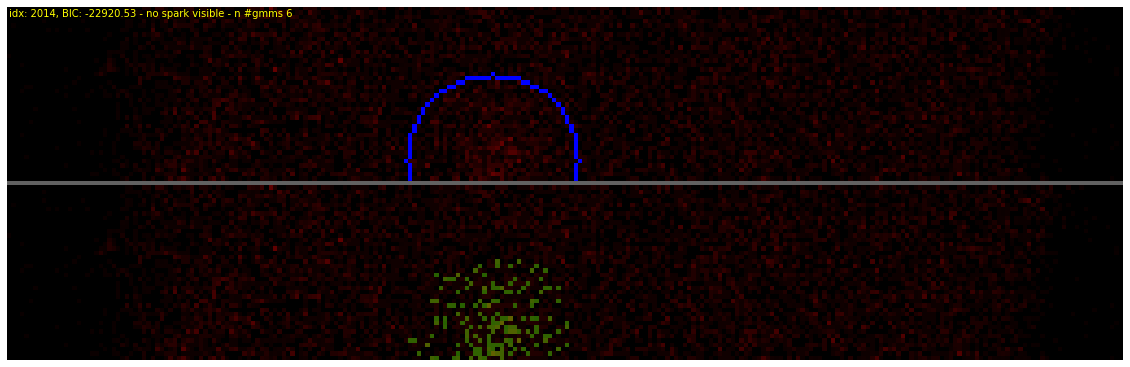

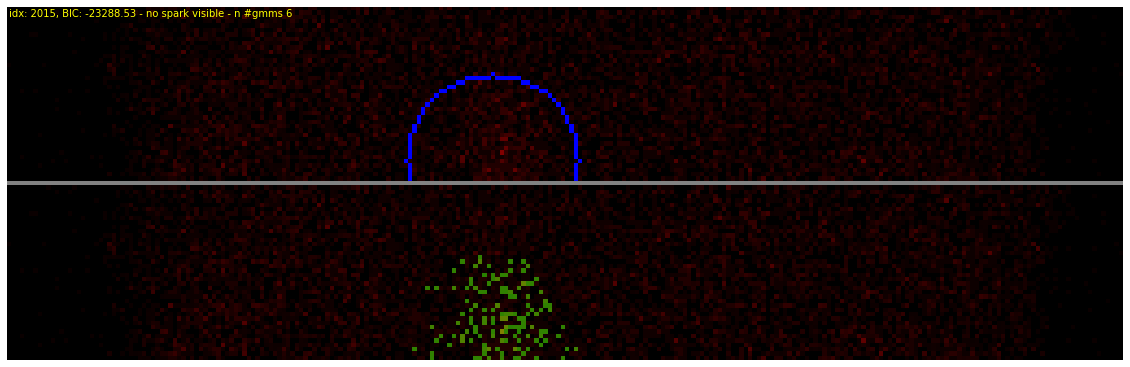

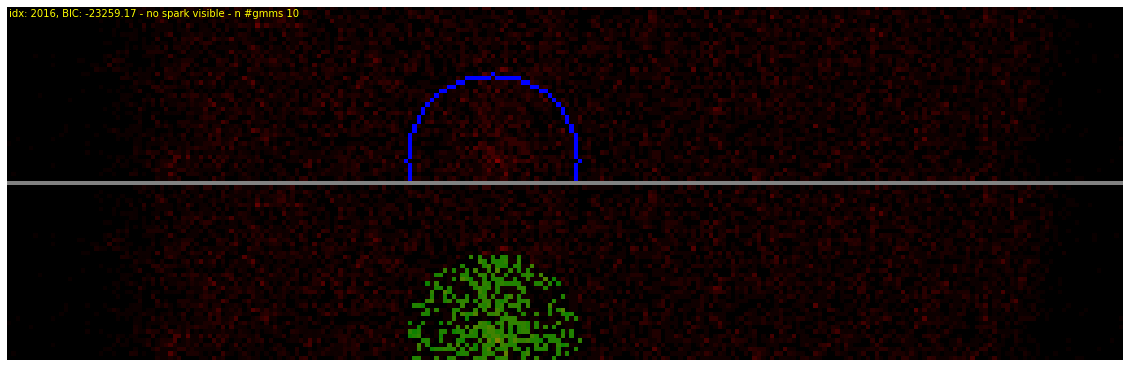

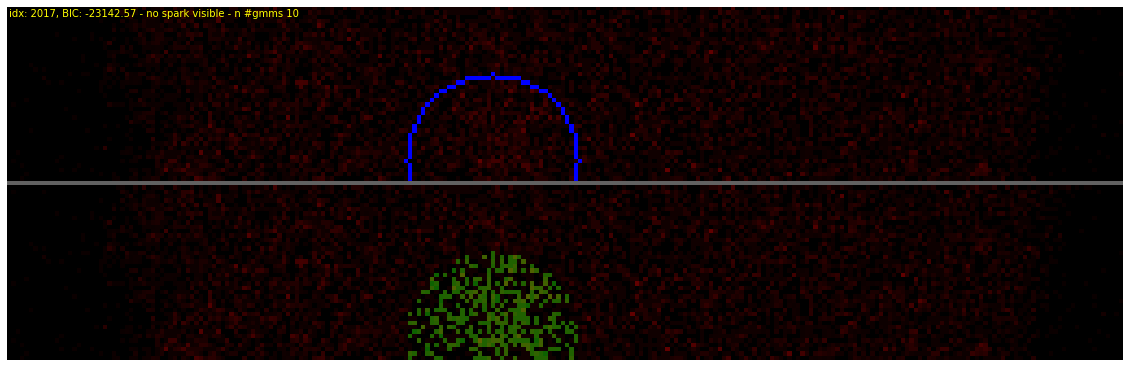

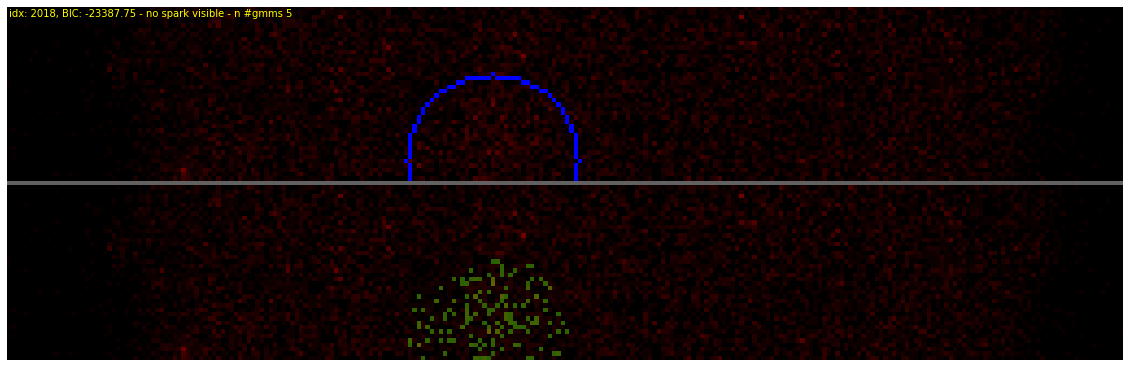

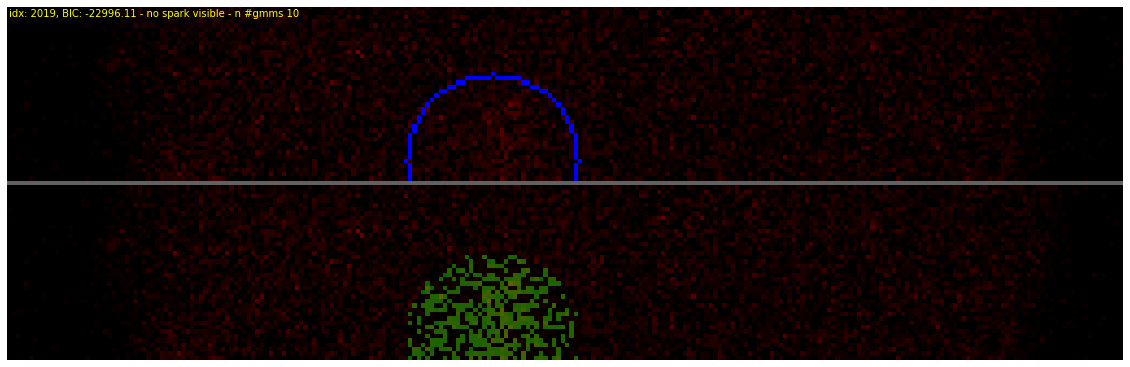

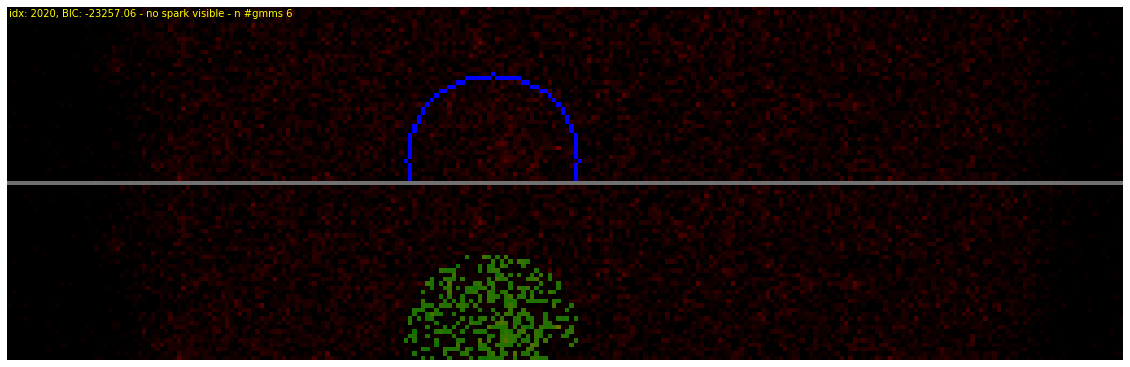

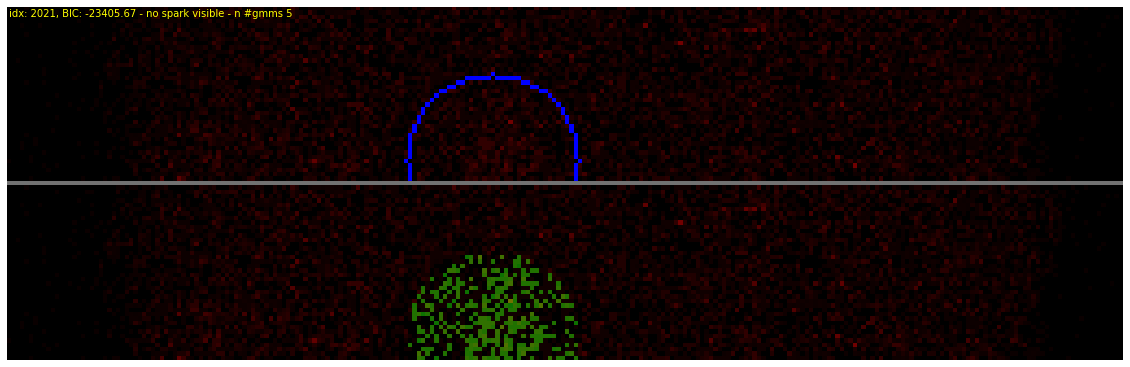

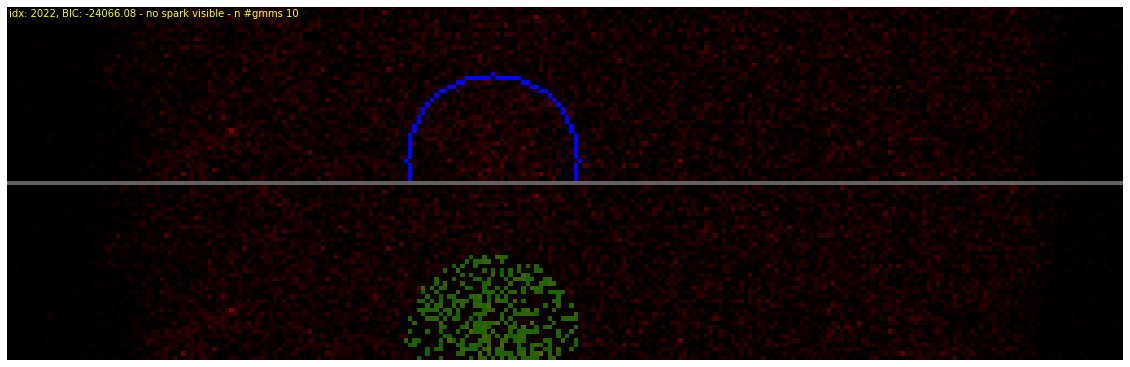

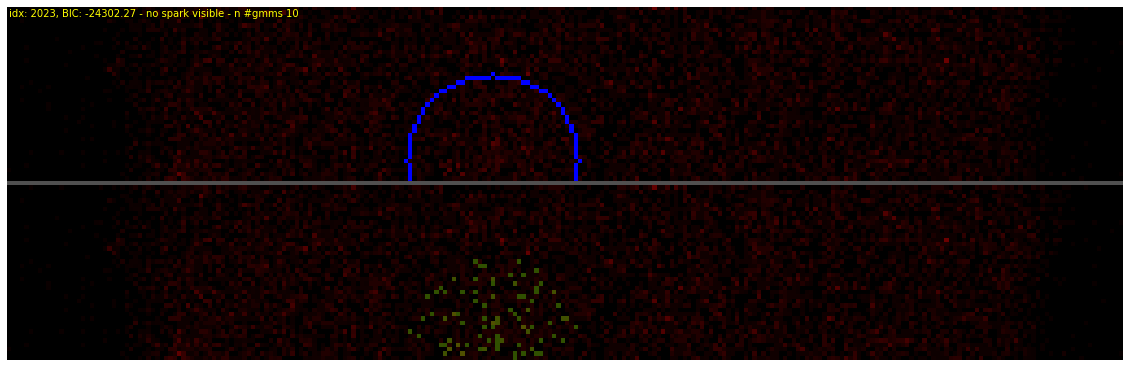

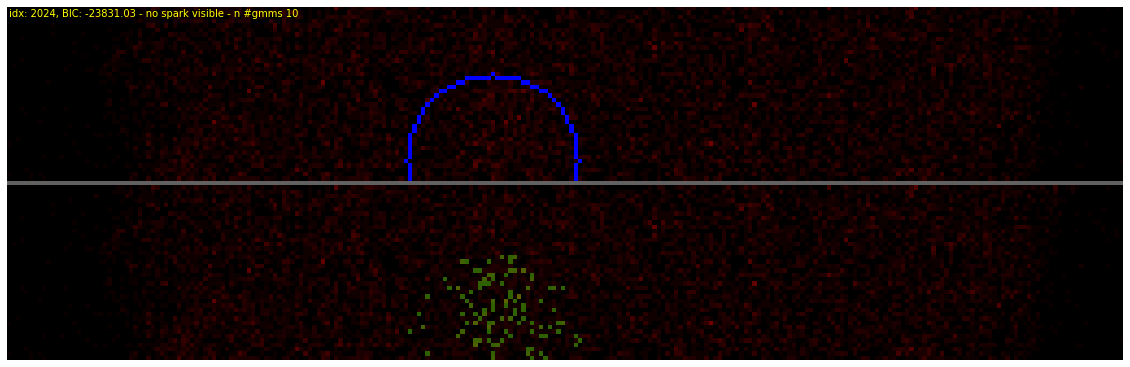

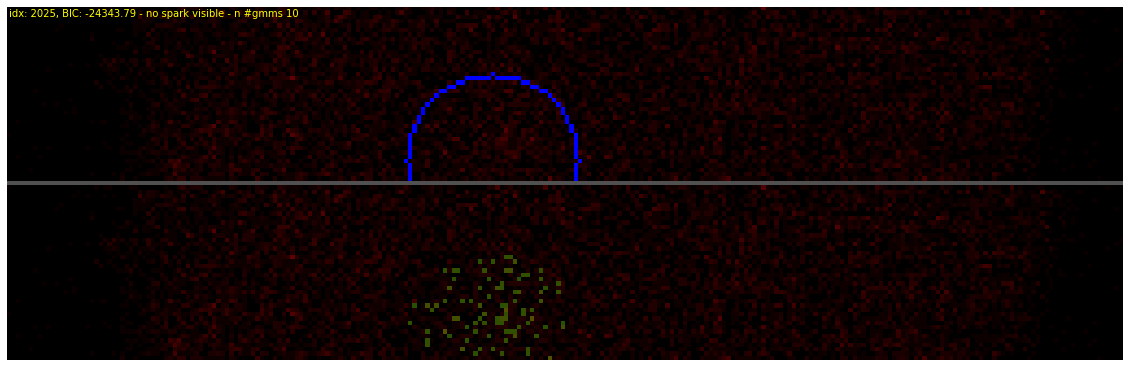

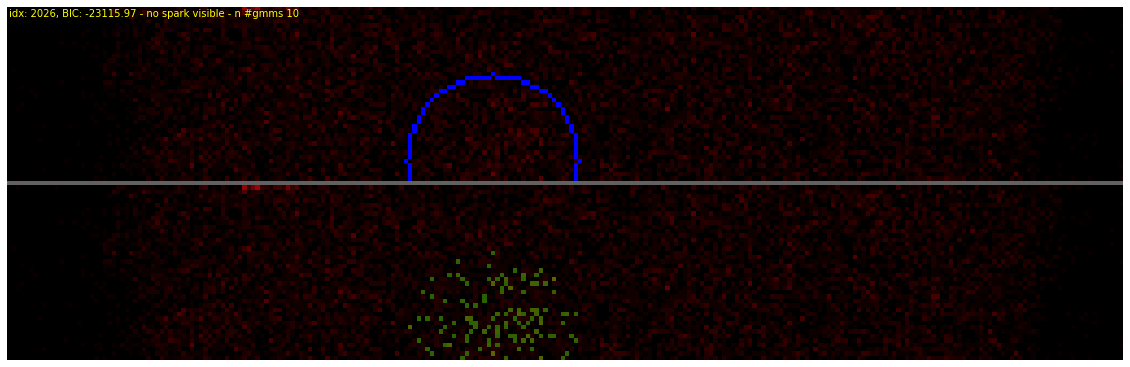

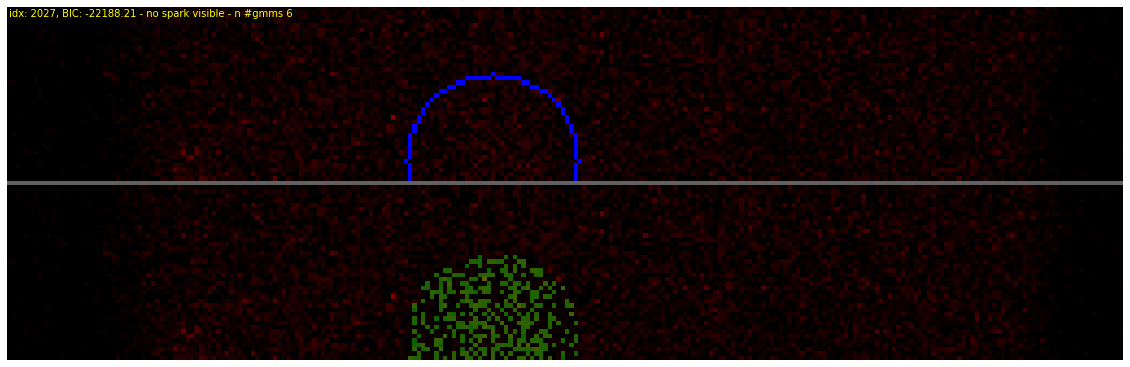

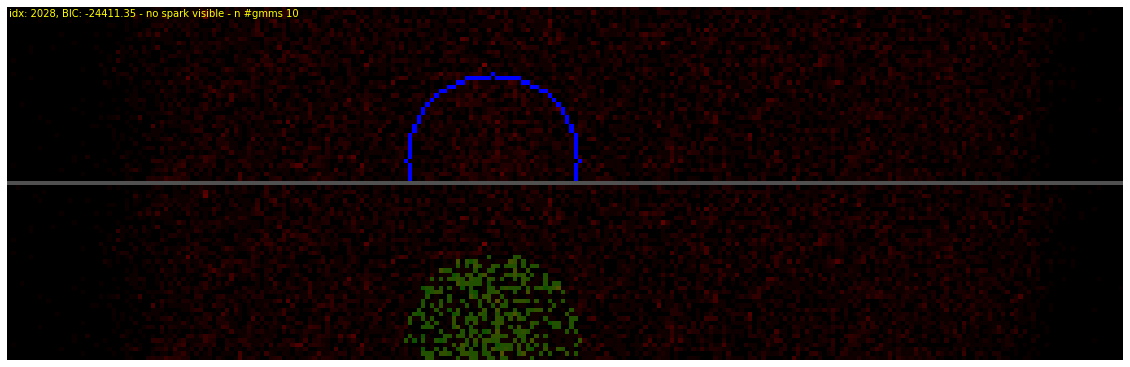

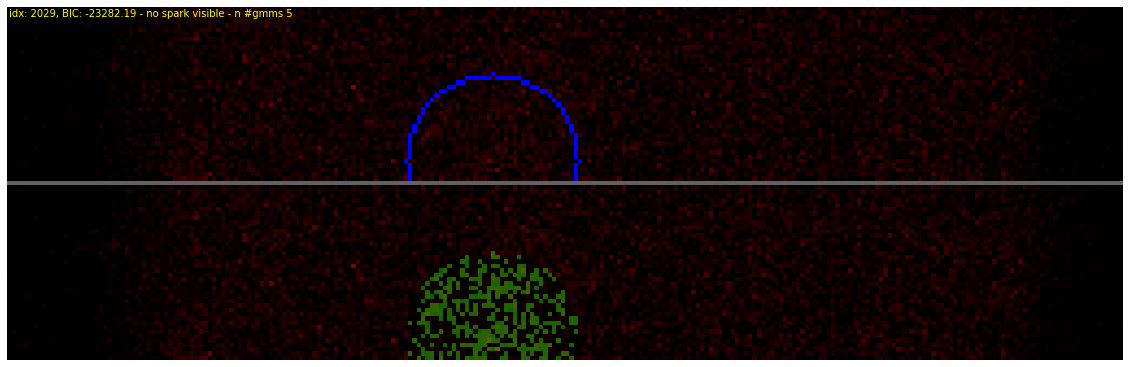

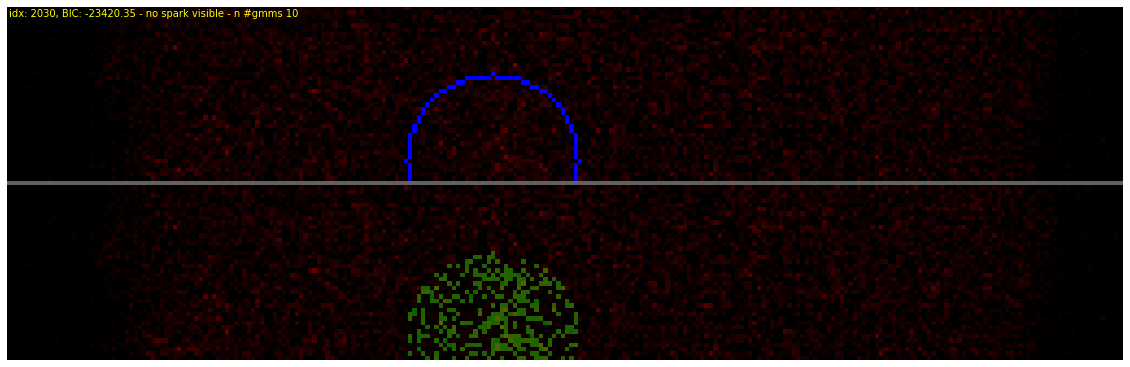

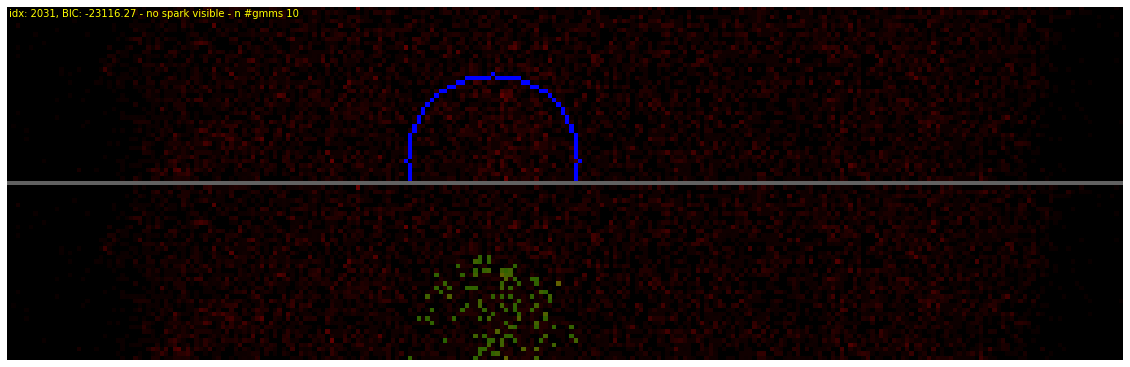

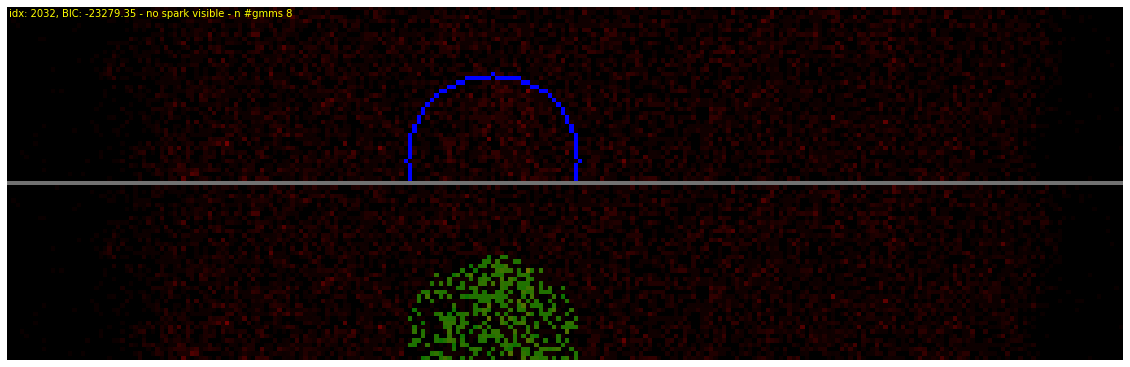

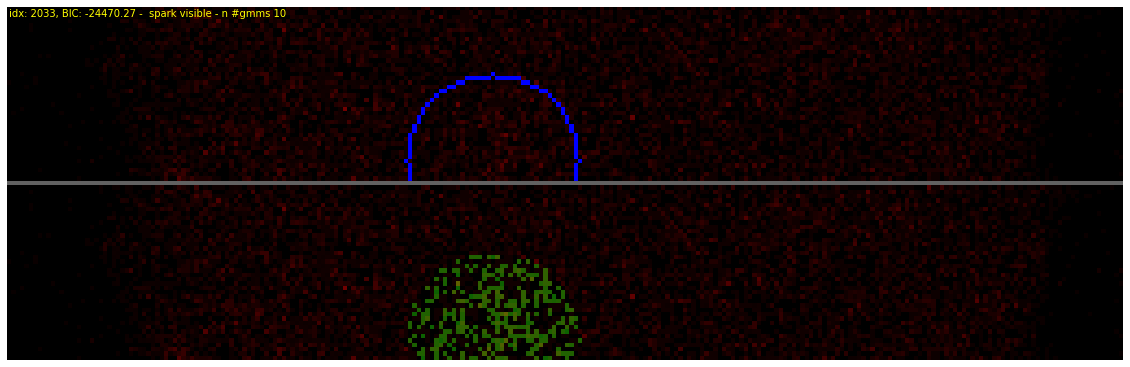

In [99]:
sparkVisibilityMask = visibilityLabels == visLabel
_, sparkS = next(sparksDF.loc[(sparksDF.loc[:, 'tIni']<=2003)&(sparksDF.loc[:, 'tFin']>=2003), :].iterrows())
for j, idx in enumerate(range(sparkS['tIni'], sparkS['tFin'])):
    im = cv2.imread(get_image_path(idx))
    im_ = im.copy()

    sparkLocations = get_spark_location(sparksDF, idx)
    gmmCounts = []
    # only first one
    i, sparkLocation = next(sparkLocations.iterrows())
    
    if sparkVisibilityMask[j] or True:
        mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20) & (im[:,:,2]>0)
    
        nComp, bic = get_optimal_ncomponents_and_bic_gmm_(im[mask].reshape(-1,1))

        gmm = mixture.GaussianMixture(n_components=2).fit(im[mask].reshape(-1,3))
        lab = gmm.predict(im[mask].reshape(-1,3))

        maxRValue = im_[mask,2].max()
        maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
        maxValueIdx = im_[mask, 2].argmax()
        isSparkCond = np.full(im_[mask].shape, False)
        isSparkCond[lab == lab[maxValueIdx], 1] = True
        im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])
    
    cv2.circle(im, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)
    conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.text(0, 0, f"idx: {idx}, BIC: {round(bics_list[j],2)} - " +\
             f"{'no' if not sparkVisibilityMask[j] else ''} spark visible - " +\
             # f"probs {', '.join(predictProbaDF.loc[j].round(2).astype(str))}" +\
             f"n #gmms {nComp}", c='yellow', verticalalignment='top')
    # plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

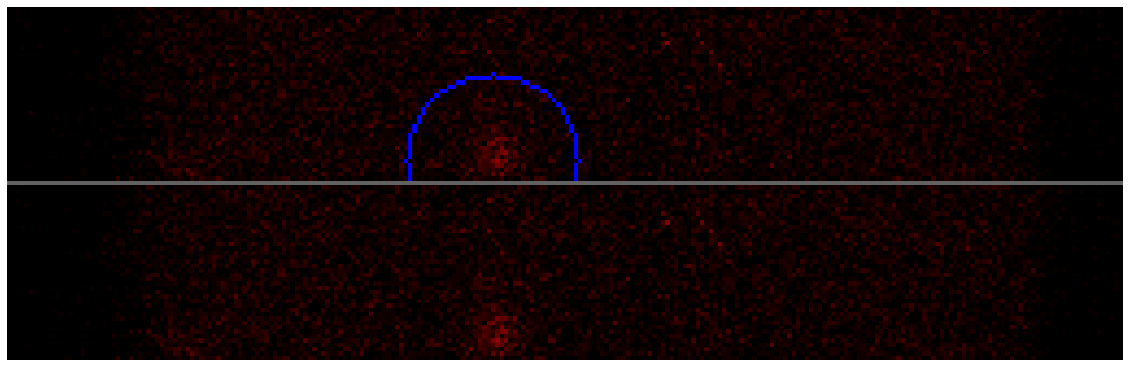

0

In [117]:
idx=2006

im = cv2.imread(get_image_path(idx))
im_ = im.copy()

mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

# tots els pixels
mask = mask & (im[:,:,2] > 0)

sparkLocations = get_spark_location(sparksDF, idx)
# only first one
i, sparkLocation = next(sparkLocations.iterrows())

nComp, bic = get_optimal_ncomponents_and_bic_gmm(im[mask].reshape(-1,1))

gmm = mixture.GaussianMixture(n_components=nComp).fit(im[mask].reshape(-1,3))
lab = gmm.predict(im[mask].reshape(-1,3))
lab = [int(p[gmm.means_[:, 2].argmax()] > 0.8) for p in gmm.predict_proba(im[mask].reshape(-1,3))]

isSparkCond = np.full(im_[mask].shape, False)
isSparkCond[lab == 1, 1] = True
im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])
cv2.circle(im, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)
conc_im = np.concatenate((im, np.full((1,im.shape[1], 3), maxRValue), im_))
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
plt.axis('off')
# plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
plt.show()

isSparkCond.sum()

### savefig spark frames GMM

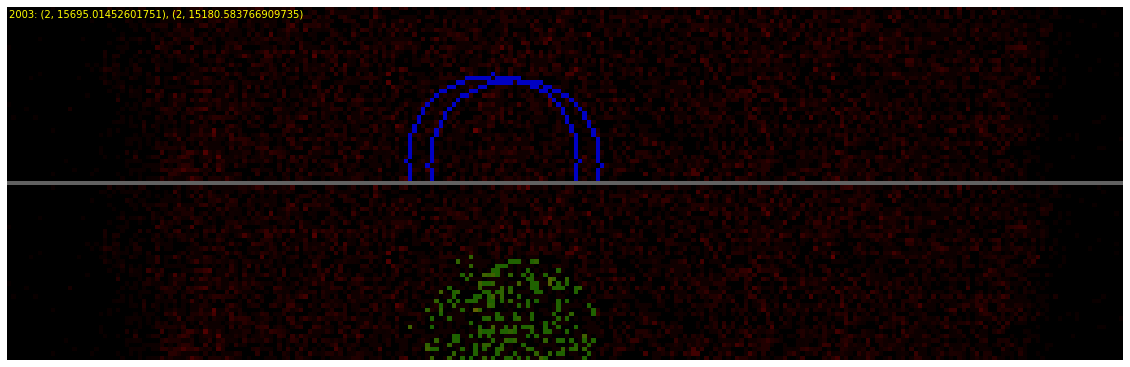

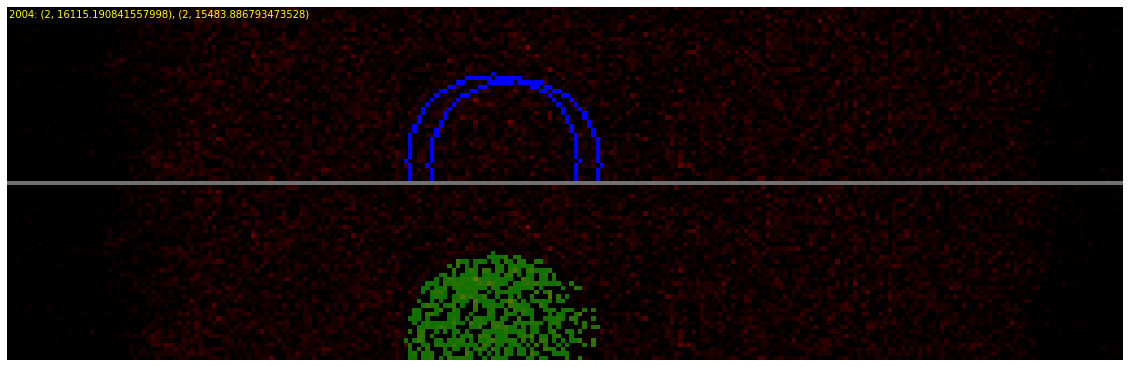

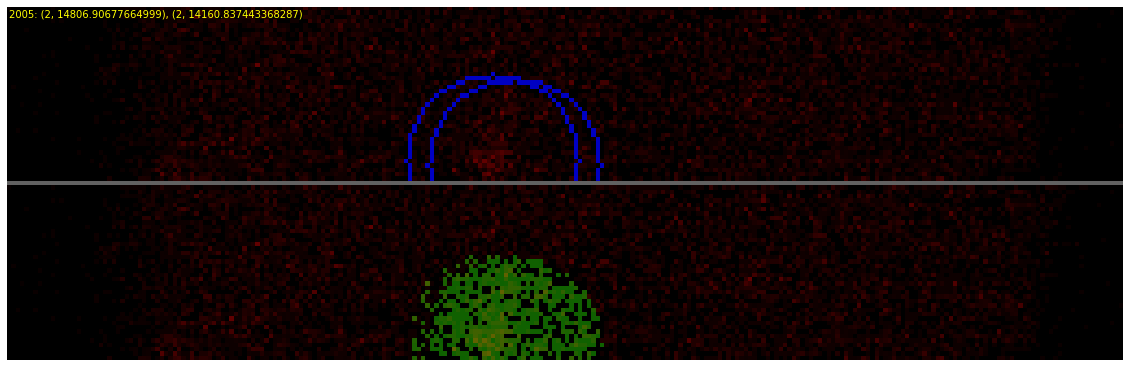

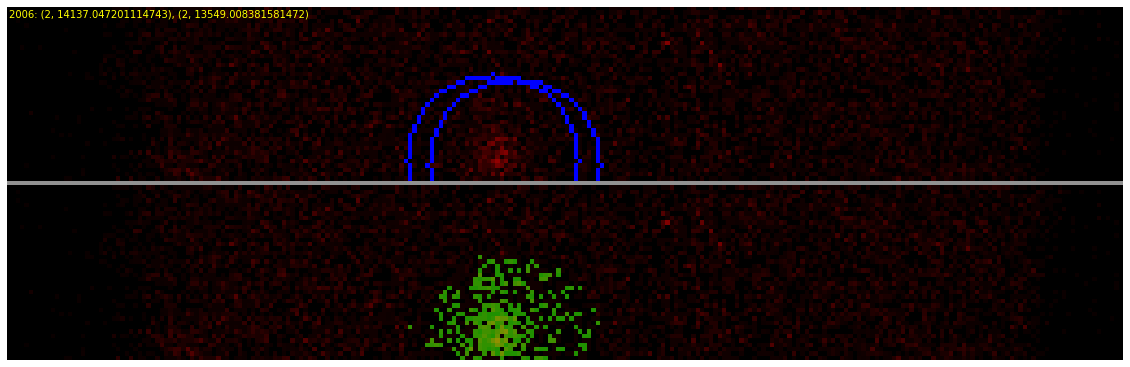

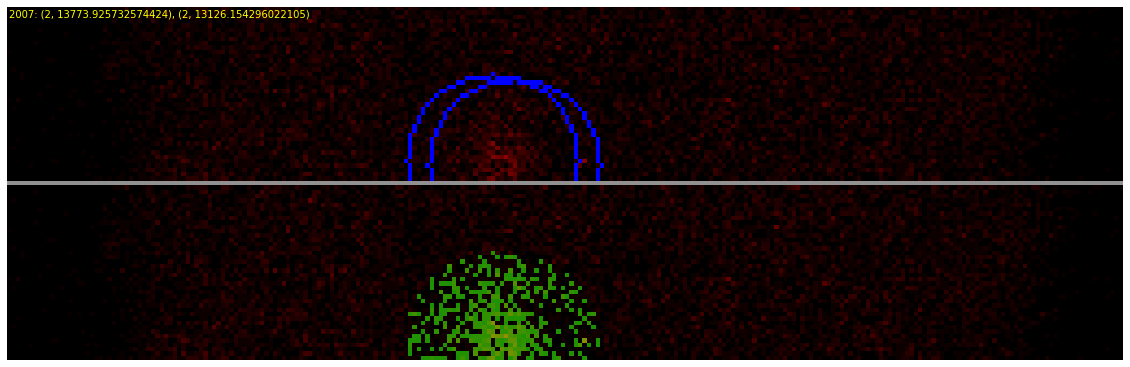

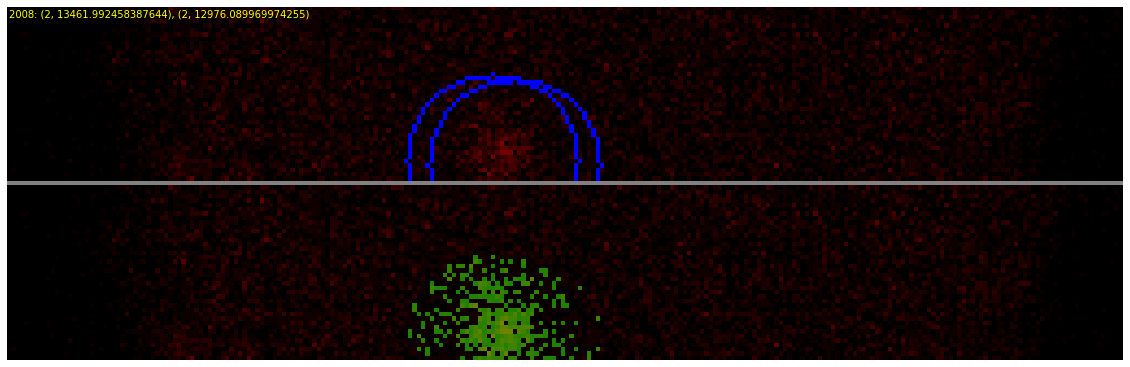

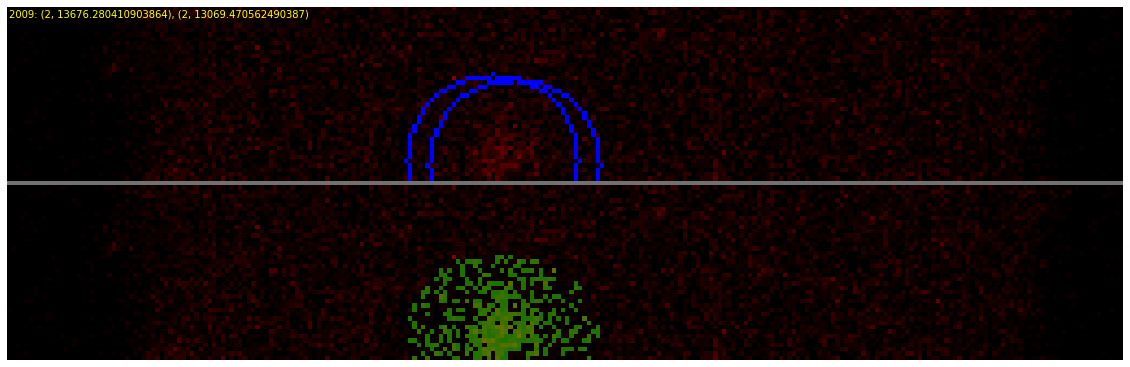

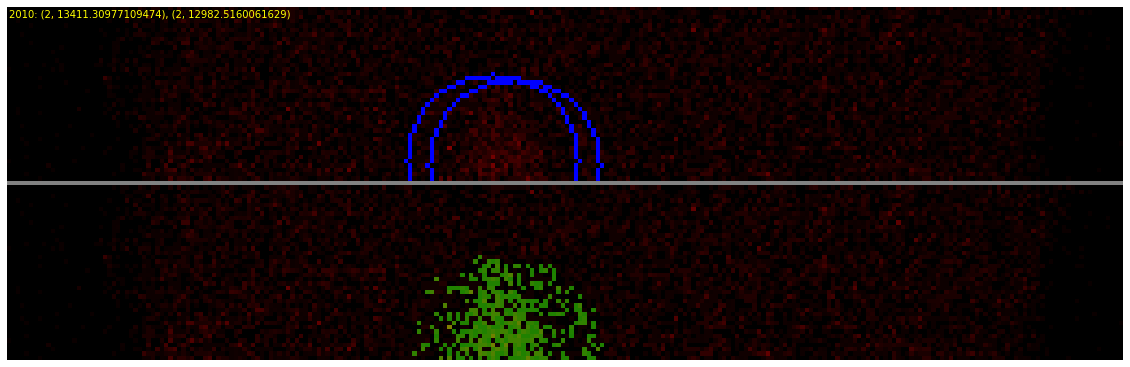

In [23]:
idx = 2008
for idx in range(2003, 2010+1):
    im = cv2.imread(get_image_path(idx))
    im_top = im.copy()
    im_ = im.copy()
    
    sparkLocations = get_spark_location(sparksDF, idx)
    gmmCounts = []
    for i, sparkLocation in sparkLocations.iterrows():
        color = int(im.max()*2)
        cv2.circle(im_top, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0)
        
        mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)
        
        nComp, bic = get_optimal_ncomponents_and_bic_gmm(im[mask].reshape(-1,1))
        
        gmmCounts.append((nComp,bic))
        gmm = mixture.GaussianMixture(n_components=(nComp)).fit(im[mask].reshape(-1,3))
        lab = gmm.predict(im[mask].reshape(-1,3))
        
        maxRValue = im[mask,2].max()
        maxValue = np.array([0, 0, maxRValue]).reshape(-1,3)
        maxValueIdx = im[mask, 2].argmax()
        isSparkCond = np.full(im_[mask].shape, False)
        isSparkCond[lab == lab[maxValueIdx], 1] = True
        im_[mask] = np.where(isSparkCond, maxRValue, im_[mask])

    conc_im = np.concatenate((im_top, np.full((1,im.shape[1], 3), maxRValue), im_))
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(conc_im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    # plt.title(f"{idx}")
    plt.text(0, 0, f"{idx}: "+', '.join(str(c) for c in gmmCounts), c='yellow', verticalalignment='top')
    # plt.savefig(f"_out/spark{idx}", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Normaization 
$F_0 = mean(F \in cell | \forall frames)$  
$F_n = \frac{F-F_0}{F_0}$

### Build cell mask

In [24]:
BACKGROUND_MAX_VALUE = 0

cellMask = np.zeros(get_image_array(0).shape)
for i in range(len(imageList)):
    im1 = get_image_array(i)
    auxMask = im1 > BACKGROUND_MAX_VALUE
    cellMask += auxMask

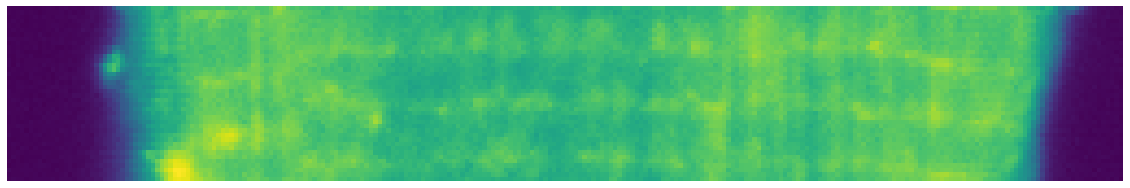

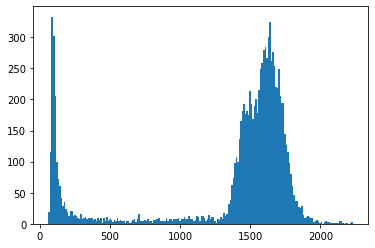

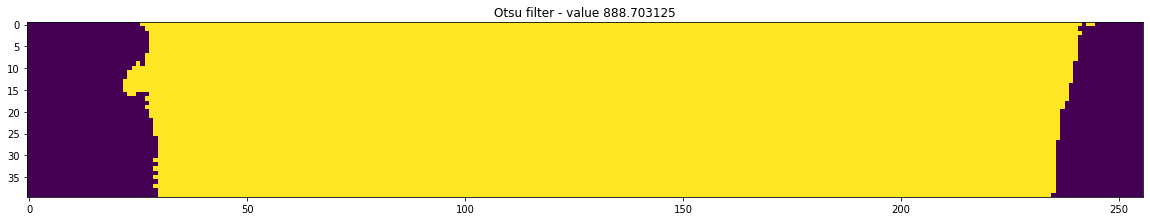

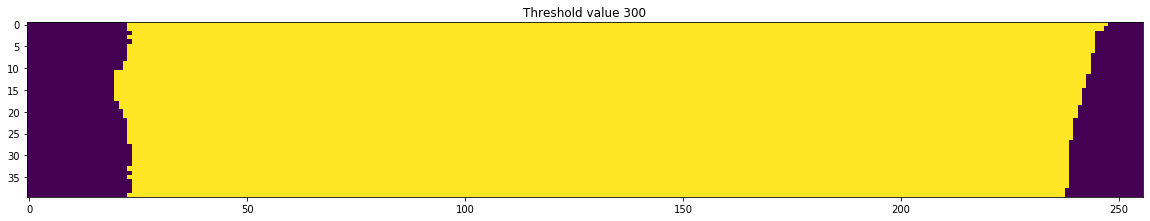

In [25]:
# cellMask = im1 > BACKGROUND_MAX_VALUE
plt.figure(figsize=(20, 10))
plt.imshow(cellMask)
plt.axis('off')
# plt.savefig(f"_out/cellmask", bbox_inches = 'tight', pad_inches = 0)
plt.show()


plt.hist(cellMask.flatten(), bins=200)
plt.show()

plt.figure(figsize=(20, 10))
thr = threshold_otsu(cellMask)
plt.imshow(cellMask > thr)
plt.title(f'Otsu filter - value {thr}')
plt.show()

plt.figure(figsize=(20, 10))
thr = 300
plt.imshow(cellMask > thr)
plt.title(f'Threshold value {thr}')
plt.show()

In [26]:
cellMask = cellMask > threshold_otsu(cellMask)

### Value counts

In [27]:
res = pd.Series(dtype='int')
for i in range(len(imageList)):
    im1 = get_image_array(i)
    s1 = pd.Series(im1[cellMask].flatten())
    g1 = s1.groupby(s1).size()
    
    res = pd.concat([res, g1], axis=1).fillna(0, downcast='infer').sum(axis=1)

# res

### F0

In [28]:
F0 = (res*res.index).sum()/res.sum()
F0

15.179870023905599

In [29]:
F0, maxValue, cellMask = get_f0_and_cellmask()

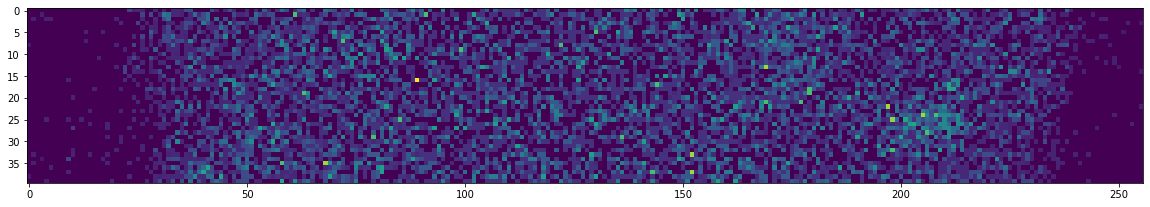

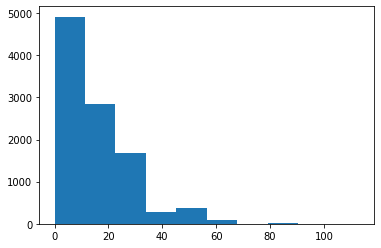

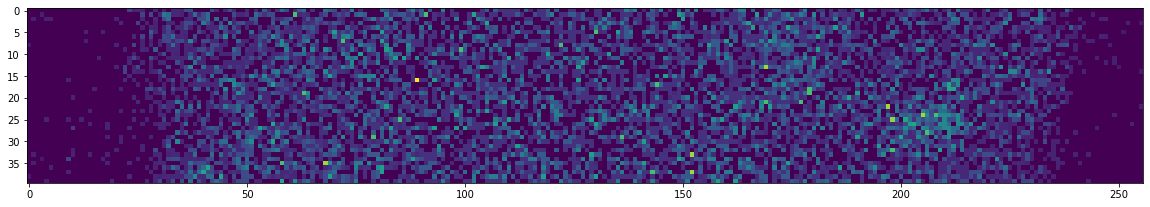

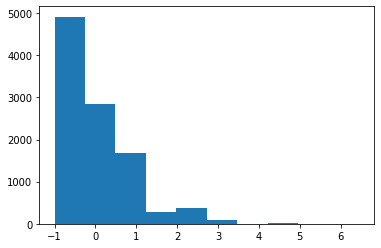

In [30]:
idx = 130
im = get_image_array(idx)

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten())
plt.show()

im = get_normalized_frame(im, F0)

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten())
plt.show()